In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', 100)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso
#from catboost import CatBoostRegressor
#from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor

## Функции

In [2]:
# возвращает список колонок, не содержащие NaN
columns_without_nan = lambda df: df.loc[:, df.notna().all(axis=0)].columns

# возвращает список колонок, содержащие NaN
columns_with_nan = lambda df: df.loc[:, df.isna().any(axis=0)].columns

# возвращает список количественных колонок
numerical_columns = lambda df: [i for i in df.columns if df[i].dtypes != 'O']

# возвращает список категориальных колонок
categorial_columns = lambda df: [i for i in df.columns if df[i].dtypes == 'O']

# возвращает таблицу, содержащую числа в диапазоне 0<=x<=1
# если 0, то все значения в данном кластере для данного параметра пусты 
# если 1 - заполненны. Иначе это доля заполненных значений.
def nan_percent_table(data, col: str):
    df = pd.DataFrame(index=columns_with_nan(data), columns=data[col].unique())
    for i in df.columns:
        df1 = data[data[col] == i]
        for j in df.index:
            df.loc[j, i] = 1 - df1[df1[j].isna()].shape[0]/df1.shape[0]
    return df

## Чтение и первичный просмотр данных

In [ ]:
X_train = pd.read_csv(r"X_train.csv")
X_test = pd.read_csv(r"X_test.csv")
y_train = pd.read_csv(r"y_train.csv")
y_test = pd.read_csv(r"y_test.csv")
X_cols = X_train.columns
y_cols = y_train.columns

In [ ]:
X_train.head(10)

engine_id  \
0  14aa1250a60229a6f0fc62e973fe757d076f897e4bc93a...   
1  6dc714d821a73d97c06143281b622c4e45c791985425c8...   
2  dda2a4e5f8b7c39356d9da1279e61b44bf4362c6cf46a0...   
3  f5a5af90e581be9a4b812c1000c5a9fa938741889bab62...   
4  364a94e57c5e7705c650bdadda955186d3a8f9d96a3d9e...   
5  d2ba0263d717e3f26c9101194229a887a29dcbaf730c8f...   
6  17347326abdfbcd8acc523a9069dba5f770f1f65ca9b21...   
7  2813cc69b6a3813712a16a86bea9f40e037279cb36ef23...   
8  9c8cd934ffbca8d075e1c2b0e70015dff7ee31e54ead92...   
9  57b8a89be497016560cb94e201d0b0b5249b279ba35a3f...   

                                         aircraft_id      flight_datetime  \
0  adb019dcde61d092941e0fec4e89b405130df238877e26...  2022-02-08 03:50:15   
1  31baf613cc66c483d5576812d060e54d64275325be437f...  2022-07-24 02:46:01   
2  47ea147feec375157fdc4ef94bce6803be3f847399e52a...  2022-05-31 22:40:14   
3  30c6570a99d5554ca6975f2ca386e7d3af1b3b92dc063e...  2022-05-25 23:50:56   
4  86b6b690d8ede50869aa2562b655a65abd786d169572b4...  2022-06-29 22:08:24   
5  7a8843ad8fc77c64ee93351cfe55a2c82284a4674a7f7b...  2022-06-10 22:47:43   
6  ac5a9ee6985da1ed0780c817d7ac0cc5ec571d9c55f56c...  2022-06-29 03:54:51   
7  467295d533d5ee94a8265c44774fe307ad915b29096dda...  2022-07-15 18:02:49   
8  8b013b1be61b0047e5a6ea6771810d71f987831f5c9329...  2022-02-27 22:53:26   
9  a0119e19d7f710c158729bc4153a6996e891b54664262b...  2022-07-19 04:38:31   

  flight_phase  engine_position  n1_modifier  number_blades engine_family  \
0      TAKEOFF                1          6.0           36.0      CFM56-5B   
1       CRUISE                2          0.0           28.0       CF34-8E   
2      TAKEOFF                2          6.0           36.0      CFM56-5B   
3       CRUISE                2          5.0           36.0      CFM56-5B   
4       CRUISE                1          4.0           24.0       CFM56-7   
5      TAKEOFF                2          0.0           24.0       CFM56-7   
6      TAKEOFF                2          0.0           28.0       CF34-8E   
7       CRUISE                1          0.0           28.0       CF34-8E   
8       CRUISE                2          3.0           36.0      CFM56-5B   
9       CRUISE                1          4.0           36.0      CFM56-5B   

     engine_type         manufacturer  ZHPTAC  ZLPTAC     ZPCN12     ZPCN25  \
0      CFM56-5B4    CFM INTERNATIONAL     NaN     NaN  83.400002  93.300003   
1       CF34-8E5  GE AIRCRAFT ENGINES     NaN     NaN  81.359299  82.984299   
2      CFM56-5B4    CFM INTERNATIONAL     NaN     NaN  84.900002  95.800003   
3      CFM56-5B4    CFM INTERNATIONAL    94.0    98.0  86.400002  95.000000   
4  CFM56-7B27/B1    CFM INTERNATIONAL     NaN     NaN  89.879997  93.690002   
5     CFM56-7B26    CFM INTERNATIONAL     NaN     NaN  95.250000  98.629997   
6       CF34-8E5  GE AIRCRAFT ENGINES     NaN     NaN  85.593697  90.125000   
7       CF34-8E5  GE AIRCRAFT ENGINES     NaN     NaN  78.390602  81.531197   
8      CFM56-5B4    CFM INTERNATIONAL    86.0    62.0  73.599998  89.699997   
9      CFM56-5B3    CFM INTERNATIONAL   100.0    99.0  85.500000  93.500000   

   ZPHSF  ZPHSR     ZPN12R      ZPOIL        ZPS3      ZT1AB         ZT3  \
0  248.0   16.0        NaN        NaN         NaN        NaN         NaN   
1    NaN    NaN  87.125000  67.714203  114.500000 -21.796801  385.187012   
2  342.0   34.0        NaN        NaN         NaN        NaN         NaN   
3  177.0   81.0        NaN  42.000000         NaN        NaN         NaN   
4    NaN    NaN        NaN  49.000000         NaN        NaN         NaN   
5    NaN    NaN        NaN        NaN         NaN        NaN         NaN   
6    NaN    NaN  83.578102  76.031700  285.375000  29.687500  498.500000   
7    NaN    NaN  84.265602  64.158699  102.686996 -23.828100  363.375000   
8   57.0  174.0        NaN  43.000000         NaN        NaN         NaN   
9  183.0  247.0        NaN  45.000000         NaN        NaN         NaN   

         ZT49      ZTAM

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47794 entries, 0 to 47793
Data columns (total 53 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   engine_id        47794 non-null  object 
 1   aircraft_id      47794 non-null  object 
 2   flight_datetime  47794 non-null  object 
 3   flight_phase     47794 non-null  object 
 4   engine_position  47794 non-null  int64  
 5   n1_modifier      47794 non-null  float64
 6   number_blades    47794 non-null  float64
 7   engine_family    47794 non-null  object 
 8   engine_type      47794 non-null  object 
 9   manufacturer     47794 non-null  object 
 10  ZHPTAC           11957 non-null  float64
 11  ZLPTAC           11957 non-null  float64
 12  ZPCN12           47794 non-null  float64
 13  ZPCN25           47794 non-null  float64
 14  ZPHSF            13336 non-null  float64
 15  ZPHSR            13336 non-null  float64
 16  ZPN12R           18382 non-null  float64
 17  ZPOIL       

In [ ]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47794 entries, 0 to 47793
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   flight_datetime  47794 non-null  object 
 1   flight_phase     47794 non-null  object 
 2   engine_id        47794 non-null  object 
 3   BRAT             47721 non-null  float64
 4   DEGT             28279 non-null  float64
 5   DELFN            9880 non-null   float64
 6   DELN1            9880 non-null   float64
 7   DELVSV           11884 non-null  float64
 8   DPOIL            19250 non-null  float64
 9   EGTC             28279 non-null  float64
 10  EGTHDM           36961 non-null  float64
 11  EGTHDM_D         18993 non-null  float64
 12  GEGTMC           19203 non-null  float64
 13  GN2MC            19203 non-null  float64
 14  GPCN25           28279 non-null  float64
 15  GWFM             28279 non-null  float64
 16  PCN12            47512 non-null  float64
 17  PCN12I      

In [ ]:
rubbish_columns = ['manufacturer', 'ac_manufacturer', 'engine_position', 'engine_family',
                   'aircraft_family']
X_train = X_train.drop(columns=rubbish_columns)

In [ ]:
data_train = pd.merge(X_train, y_train,
                   on=["engine_id", "flight_datetime", "flight_phase"])
y_train = pd.merge(X_train[categorial_columns(X_train)], y_train,
                   on=["engine_id", "flight_datetime", "flight_phase"])
X_train = X_train.drop(columns=['engine_id', 'aircraft_id', 'flight_datetime'])
y_train = y_train.drop(columns=['engine_id', 'aircraft_id', 'flight_datetime'])
data_train = data_train.drop(columns=['engine_id', 'aircraft_id', 'flight_datetime'])
X_cols = X_train.columns
y_cols = y_train.columns

In [ ]:
nan_percent_table(data_train, 'engine_type')

CFM56-5B4  CF34-8E5 CFM56-7B27/B1 CFM56-7B26 CFM56-5B3
ZHPTAC    0.803416       0.0           0.0        0.0  0.898343
ZLPTAC    0.803416       0.0           0.0        0.0  0.898343
ZPHSF     0.999517       0.0           0.0        0.0  0.736829
ZPHSR     0.999517       0.0           0.0        0.0  0.736829
ZPN12R         0.0  0.999946           0.0        0.0       0.0
ZPOIL     0.803416       1.0      0.512959   0.500532  0.894385
ZPS3           0.0  0.999891           0.0        0.0       0.0
ZT1AB          0.0  0.999946           0.0        0.0       0.0
ZT3            0.0  0.999891           0.0        0.0       0.0
ZTAMB          0.0       1.0           0.0        0.0       0.0
ZTLA           0.0       1.0           0.0        0.0       0.0
ZTNAC     0.803416       0.0           0.0        0.0  0.898343
ZTOIL     0.803416       1.0      0.512959   0.500532  0.894385
ZVB1F     0.999517       1.0           1.0        1.0       1.0
ZVB1R     0.999517       0.0      0.487041   0.499468       1.0
ZVB2F     0.998456       0.0      0.487041   0.499468       1.0
ZVB2R     0.998456       1.0      0.487041   0.499468       1.0
ZVSV      0.803416  0.999891           0.0        0.0  0.898343
ZWF36     0.803416       1.0      0.512959   0.500532  0.898343
IHPSOV         0.0       1.0           0.0        0.0       0.0
AGW            1.0       0.0           1.0        1.0       1.0
CAS            1.0       0.0      0.487041   0.499468       1.0
IAI       0.196584  0.506011      0.487041   0.499468  0.101657
IVS12          1.0       0.0           1.0        1.0       1.0
SAT            0.0       0.0           1.0        1.0       0.0
ZVIAS          0.0  0.999891           0.0        0.0       0.0
ZWBP1          1.0       0.0           0.0        0.0       1.0
ZWBP1_8E       0.0       1.0           0.0        0.0       0.0
ZWBP2          1.0       0.0           0.0        0.0       1.0
ZWBP2_8E       0.0       1.0           0.0        0.0       0.0
IBP            0.0       1.0           1.0        1.0       0.0
IAIE      0.196584       1.0      0.487041   0.499468  0.101657
BRAT           1.0       1.0           1.0        1.0  0.981944
DEGT      0.794924  0.493717      0.507019   0.490877  0.883008
DELFN     0.196101  0.000054      0.486501   0.498328   0.09671
DELN1     0.196101  0.000054      0.486501   0.498328   0.09671
DELVSV    0.796661       0.0           0.0        0.0  0.897601
DPOIL     0.795503       0.0      0.507019   0.490877  0.893149
EGTC      0.794924  0.493717      0.507019   0.490877  0.883008
EGTHDM    0.974812  0.503509      0.985961   0.949293     0.814
EGTHDM_D  0.196294  0.503509      0.468683   0.491333  0.092011
GEGTMC    0.794924       0.0      0.507019   0.490877  0.883008
GN2MC     0.794924       0.0      0.507019   0.490877  0.883008
GPCN25    0.794924  0.493717      0.507019   0.490877  0.883008
GWFM      0.794924  0.493717      0.507019   0.490877  0.883008
PCN12     0.992279  0.997443      0.993521   0.989281  0.999505
PCN12I    0.992279  0.493935      0.993521   0.989281  0.999505
PCN1AR    0.196391       0.0      0.486501   0.498404  0.101657
PCN1BR    0.196584       0.0      0.487041   0.499468  0.101657
PCN1K     0.991507  0.997226      0.992441   0.984795  0.993569
PCN2C     0.794924  0.493717      0.507019   0.490877  0.883008
SLOATL    0.974812  0.503509      0.985961   0.949293     0.814
SLOATL_D  0.196294  0.503509      0.468683   0.491333  0.092011
VSVNOM    0.796661       0.0           0.0        0.0  0.897601
WBE         0.9199       0.0           0.0        0.0    0.9488
WBI       0.803416  0.493935      0.512959   0.500532  0.898343
WFMP      0.794924  0.493717      0.507019   0.490877  0.883008
ZPCN25_D       1.0       1.0      0.968143   0.994678  0.997279
ZT49_D         1.0       1.0      0.968143   0.994678  0.997279
ZTLA_D         0.0  0.493935           0.0        0.0       0.0
ZTNAC_D   0.803416       0.0           0.0        0.0  0.895869
ZWF36_D   0.803416       1.0       0.4978

In [ ]:
# data = data_train[(data_train['PCN1K'].notna()) & (data_train['engine_type'] == 'CFM56-5B4') |
#                  (data_train['engine_type'] != 'CFM56-5B4')]

In [ ]:
# nan_percent_table(data, 'flight_phase')

In [ ]:
# X_train[(['2022-01' in i for i in X_train['flight_datetime']])]

In [ ]:
nan_percent_table(data_train, 'engine_type')

CFM56-5B4  CF34-8E5 CFM56-7B27/B1 CFM56-7B26 CFM56-5B3
ZHPTAC    0.803416       0.0           0.0        0.0  0.898343
ZLPTAC    0.803416       0.0           0.0        0.0  0.898343
ZPHSF     0.999517       0.0           0.0        0.0  0.736829
ZPHSR     0.999517       0.0           0.0        0.0  0.736829
ZPN12R         0.0  0.999946           0.0        0.0       0.0
ZPOIL     0.803416       1.0      0.512959   0.500532  0.894385
ZPS3           0.0  0.999891           0.0        0.0       0.0
ZT1AB          0.0  0.999946           0.0        0.0       0.0
ZT3            0.0  0.999891           0.0        0.0       0.0
ZTAMB          0.0       1.0           0.0        0.0       0.0
ZTLA           0.0       1.0           0.0        0.0       0.0
ZTNAC     0.803416       0.0           0.0        0.0  0.898343
ZTOIL     0.803416       1.0      0.512959   0.500532  0.894385
ZVB1F     0.999517       1.0           1.0        1.0       1.0
ZVB1R     0.999517       0.0      0.487041   0.499468       1.0
ZVB2F     0.998456       0.0      0.487041   0.499468       1.0
ZVB2R     0.998456       1.0      0.487041   0.499468       1.0
ZVSV      0.803416  0.999891           0.0        0.0  0.898343
ZWF36     0.803416       1.0      0.512959   0.500532  0.898343
IHPSOV         0.0       1.0           0.0        0.0       0.0
AGW            1.0       0.0           1.0        1.0       1.0
CAS            1.0       0.0      0.487041   0.499468       1.0
IAI       0.196584  0.506011      0.487041   0.499468  0.101657
IVS12          1.0       0.0           1.0        1.0       1.0
SAT            0.0       0.0           1.0        1.0       0.0
ZVIAS          0.0  0.999891           0.0        0.0       0.0
ZWBP1          1.0       0.0           0.0        0.0       1.0
ZWBP1_8E       0.0       1.0           0.0        0.0       0.0
ZWBP2          1.0       0.0           0.0        0.0       1.0
ZWBP2_8E       0.0       1.0           0.0        0.0       0.0
IBP            0.0       1.0           1.0        1.0       0.0
IAIE      0.196584       1.0      0.487041   0.499468  0.101657
BRAT           1.0       1.0           1.0        1.0  0.981944
DEGT      0.794924  0.493717      0.507019   0.490877  0.883008
DELFN     0.196101  0.000054      0.486501   0.498328   0.09671
DELN1     0.196101  0.000054      0.486501   0.498328   0.09671
DELVSV    0.796661       0.0           0.0        0.0  0.897601
DPOIL     0.795503       0.0      0.507019   0.490877  0.893149
EGTC      0.794924  0.493717      0.507019   0.490877  0.883008
EGTHDM    0.974812  0.503509      0.985961   0.949293     0.814
EGTHDM_D  0.196294  0.503509      0.468683   0.491333  0.092011
GEGTMC    0.794924       0.0      0.507019   0.490877  0.883008
GN2MC     0.794924       0.0      0.507019   0.490877  0.883008
GPCN25    0.794924  0.493717      0.507019   0.490877  0.883008
GWFM      0.794924  0.493717      0.507019   0.490877  0.883008
PCN12     0.992279  0.997443      0.993521   0.989281  0.999505
PCN12I    0.992279  0.493935      0.993521   0.989281  0.999505
PCN1AR    0.196391       0.0      0.486501   0.498404  0.101657
PCN1BR    0.196584       0.0      0.487041   0.499468  0.101657
PCN1K     0.991507  0.997226      0.992441   0.984795  0.993569
PCN2C     0.794924  0.493717      0.507019   0.490877  0.883008
SLOATL    0.974812  0.503509      0.985961   0.949293     0.814
SLOATL_D  0.196294  0.503509      0.468683   0.491333  0.092011
VSVNOM    0.796661       0.0           0.0        0.0  0.897601
WBE         0.9199       0.0           0.0        0.0    0.9488
WBI       0.803416  0.493935      0.512959   0.500532  0.898343
WFMP      0.794924  0.493717      0.507019   0.490877  0.883008
ZPCN25_D       1.0       1.0      0.968143   0.994678  0.997279
ZT49_D         1.0       1.0      0.968143   0.994678  0.997279
ZTLA_D         0.0  0.493935           0.0        0.0       0.0
ZTNAC_D   0.803416       0.0           0.0        0.0  0.895869
ZWF36_D   0.803416       1.0       0.4978

In [ ]:
for i in data_train['aircraft_type'].unique():
    print(i, data_train[data_train['aircraft_type'] == i]['engine_type'].unique())

A320-200 ['CFM56-5B4']
ERJ170 ['CF34-8E5']
B737-800 ['CFM56-7B27/B1' 'CFM56-7B26']
A321-200 ['CFM56-5B3']


In [ ]:
data_train["type"] = data_train["flight_phase"] + " "+ data_train["engine_type"]
data_train["type"].unique()
nan_matrix = nan_percent_table(data_train, 'type')
nan_matrix

TAKEOFF CFM56-5B4 CRUISE CF34-8E5 CRUISE CFM56-5B4  \
ZHPTAC                 0.0             0.0              1.0   
ZLPTAC                 0.0             0.0              1.0   
ZPHSF                  1.0             0.0         0.999399   
ZPHSR                  1.0             0.0         0.999399   
ZPN12R                 0.0         0.99989              0.0   
ZPOIL                  0.0             1.0              1.0   
ZPS3                   0.0         0.99989              0.0   
ZT1AB                  0.0         0.99989              0.0   
ZT3                    0.0         0.99989              0.0   
ZTAMB                  0.0             1.0              0.0   
ZTLA                   0.0             1.0              0.0   
ZTNAC                  0.0             0.0              1.0   
ZTOIL                  0.0             1.0              1.0   
ZVB1F                  1.0             1.0         0.999399   
ZVB1R                  1.0             0.0         0.999399   
ZVB2F             0.998036             0.0         0.998559   
ZVB2R             0.998036             1.0         0.998559   
ZVSV                   0.0         0.99989              1.0   
ZWF36                  0.0             1.0              1.0   
IHPSOV                 0.0             1.0              0.0   
AGW                    1.0             0.0              1.0   
CAS                    1.0             0.0              1.0   
IAI                    1.0             0.0              0.0   
IVS12                  1.0             0.0              1.0   
SAT                    0.0             0.0              0.0   
ZVIAS                  0.0         0.99989              0.0   
ZWBP1                  1.0             0.0              1.0   
ZWBP1_8E               0.0             1.0              0.0   
ZWBP2                  1.0             0.0              1.0   
ZWBP2_8E               0.0             1.0              0.0   
IBP                    0.0             1.0              0.0   
IAIE                   1.0             1.0              0.0   
BRAT                   1.0             1.0              1.0   
DEGT                   0.0        0.999559         0.989429   
DELFN             0.997545             0.0              0.0   
DELN1             0.997545             0.0              0.0   
DELVSV                 0.0             0.0         0.991592   
DPOIL                  0.0             0.0          0.99015   
EGTC                   0.0        0.999559         0.989429   
EGTHDM            0.998527             0.0         0.969009   
EGTHDM_D          0.998527             0.0              0.0   
GEGTMC                 0.0             0.0         0.989429   
GN2MC                  0.0             0.0         0.989429   
GPCN25                 0.0        0.999559         0.989429   
GWFM                   0.0        0.999559         0.989429   
PCN12             0.999018             1.0         0.990631   
PCN12I            0.999018             1.0         0.990631   
PCN1AR            0.999018             0.0              0.0   
PCN1BR                 1.0             0.0              0.0   
PCN1K             0.998527        0.999559          0.98979   
PCN2C                  0.0        0.999559         0.989429   
SLOATL            0.998527             0.0         0.969009   
SLOATL_D          0.998527             0.0              0.0   
VSVNOM                 0.0             0.0         0.991592   
WBE               0.603338             0.0         0.997357   
WBI                    0.0             1.0              1.0   
WFMP                   0.0        0.999559         0.989429   
ZPCN25_D               1.0             1.0              1.0   
ZT49_D                 1.0             1.0              1.0   
ZTLA_D                 0.0             1.0              0.0   
ZTNAC_D                0.0             0.0              1.0   
ZWF36_D                0.0             1.0              1.0   

         CRUISE CFM56-7B27/B1 TAKEOFF C

## Чистка исходных данных в X_train+y_train

In [ ]:
data_new = data_train.copy()
data_new.shape

(47794, 76)

In [ ]:
# Удаление записей, из-за которых значения в nan_matrix отклоняются от 0 или 1
for i in nan_matrix.columns:
    for j in nan_matrix.index:
        i1, i2 = i.split()
        if 1 > nan_matrix.loc[j, i] > 0.50:
            data_new = data_new.drop(data_new[(data_new[j].isna()) 
                                              & (data_new['engine_type'] == i2) 
                                              & (data_new['flight_phase'] == i1)].index)
        elif 0 < nan_matrix.loc[j, i] < 0.1:
            data_new = data_new.drop(data_new[(data_new[j].notna()) 
                                              & (data_new['engine_type'] == i2) 
                                              & (data_new['flight_phase'] == i1)].index)

In [ ]:
# data_new = data_new.drop(data_new[(data_new['PCN12'].isna()) & (data_new['engine_type'] == 'CFM56-5B4') 
#          & (data_new['flight_phase'] == 'TAKEOFF')].index)
data_new.shape

(44372, 76)

In [ ]:
nan_matrix = nan_percent_table(data_new, 'type')
nan_matrix

TAKEOFF CFM56-5B4 CRUISE CF34-8E5 CRUISE CFM56-5B4  \
ZHPTAC                 0.0             0.0              1.0   
ZLPTAC                 0.0             0.0              1.0   
ZPHSF                  1.0             0.0              1.0   
ZPHSR                  1.0             0.0              1.0   
ZPN12R                 0.0             1.0              0.0   
ZPOIL                  0.0             1.0              1.0   
ZPS3                   0.0             1.0              0.0   
ZT1AB                  0.0             1.0              0.0   
ZT3                    0.0             1.0              0.0   
ZTAMB                  0.0             1.0              0.0   
ZTLA                   0.0             1.0              0.0   
ZTNAC                  0.0             0.0              1.0   
ZTOIL                  0.0             1.0              1.0   
ZVB1R                  1.0             0.0              1.0   
ZVB2F                  1.0             0.0              1.0   
ZVB2R                  1.0             1.0              1.0   
ZVSV                   0.0             1.0              1.0   
ZWF36                  0.0             1.0              1.0   
IHPSOV                 0.0             1.0              0.0   
AGW                    1.0             0.0              1.0   
CAS                    1.0             0.0              1.0   
IAI                    1.0             0.0              0.0   
IVS12                  1.0             0.0              1.0   
SAT                    0.0             0.0              0.0   
ZVIAS                  0.0             1.0              0.0   
ZWBP1                  1.0             0.0              1.0   
ZWBP1_8E               0.0             1.0              0.0   
ZWBP2                  1.0             0.0              1.0   
ZWBP2_8E               0.0             1.0              0.0   
IBP                    0.0             1.0              0.0   
IAIE                   1.0             1.0              0.0   
DEGT                   0.0             1.0              1.0   
DELFN                  1.0             0.0              0.0   
DELN1                  1.0             0.0              0.0   
DELVSV                 0.0             0.0              1.0   
DPOIL                  0.0             0.0              1.0   
EGTC                   0.0             1.0              1.0   
EGTHDM                 1.0             0.0              1.0   
EGTHDM_D               1.0             0.0              0.0   
GEGTMC                 0.0             0.0              1.0   
GN2MC                  0.0             0.0              1.0   
GPCN25                 0.0             1.0              1.0   
GWFM                   0.0             1.0              1.0   
PCN12I                 1.0             1.0              1.0   
PCN1AR                 1.0             0.0              0.0   
PCN1BR                 1.0             0.0              0.0   
PCN2C                  0.0             1.0              1.0   
SLOATL                 1.0             0.0              1.0   
SLOATL_D               1.0             0.0              0.0   
VSVNOM                 0.0             0.0              1.0   
WBE                    1.0             0.0              1.0   
WBI                    0.0             1.0              1.0   
WFMP                   0.0             1.0              1.0   
ZTLA_D                 0.0             1.0              0.0   
ZTNAC_D                0.0             0.0              1.0   
ZWF36_D                0.0             1.0              1.0   

         CRUISE CFM56-7B27/B1 TAKEOFF CFM56-7B26 TAKEOFF CF34-8E5  \
ZHPTAC                    0.0                0.0              0.0   
ZLPTAC                    0.0                0.0              0.0   
ZPHSF                     0.0                0.0              0.0   
ZPHSR                     0.0                0.0              0.0   
ZPN12R                    0.0                0.0              1.0   
ZPO

In [ ]:
print(f'Доля удалённых записей: {(data_train.shape[0] - data_new.shape[0])/data_train.shape[0]}')

Доля удалённых записей: 0.07159894547432732


In [ ]:
# for i in nan_matrix.columns[1:6]:
#     i1, i2 = i.split()
#     data_new[(data_new['flight_phase'] == i1) 
#              & (data_new['engine_type'] == i2)].to_csv(i.replace('/', '!')+'.csv', index=False)

In [ ]:
lin_model = LinearRegression()
las_model = Lasso(alpha=60)
cat_model = CatBoostRegressor(iterations=2000)
xgb_model = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                         learning_rate=0.05, max_depth=3, 
                         min_child_weight=1.7817, n_estimators=2200,
                         reg_alpha=0.4640, reg_lambda=0.8571,
                         subsample=0.5213, random_state=7, nthread=-1)
lgb_model = LGBMRegressor()

NameError: name 'CatBoostRegressor' is not defined

In [ ]:
y_cols[4:]

In [ ]:
columns_without_nan(data_new)
features = ['n1_modifier', 'number_blades', 'ZPCN12',
       'ZPCN25', 'ZT49', 'ZVB1F', 'aircraft_type', 'aircraft_grp', 'ZALT',
       'ZT1A', 'ZXM', 'IBE', 'BRAT', 'PCN12', 'PCN1K', 'ZPCN25_D', 'ZT49_D']


# Матрица моделей (для каждого кластера и целевого параметра)
models = dict()
models_matrix = pd.DataFrame(data=CatBoostRegressor(iterations=2000), columns=nan_matrix.columns, index=y_cols[4:])
models_matrix

In [ ]:
nan_matrix

## Работа с валидационными данными, тренировка и предсказание

In [3]:
X_valid = pd.read_csv(r"X_valid.csv")
X_valid["type"] = X_valid["flight_phase"] + " "+ X_valid["engine_type"]
nan_valid_matrix = nan_percent_table(X_valid, 'type')
nan_valid_matrix

TAKEOFF CF34-8E5 TAKEOFF CFM56-7B26 CRUISE CFM56-5B4 CRUISE CF34-8E5  \
ZHPTAC                0.0                0.0              1.0             0.0   
ZLPTAC                0.0                0.0              1.0             0.0   
ZPHSF                 0.0                0.0         0.999406             0.0   
ZPHSR                 0.0                0.0         0.999406             0.0   
ZPN12R                1.0                0.0              0.0             1.0   
ZPOIL                 1.0                0.0              1.0             1.0   
ZPS3             0.999821                0.0              0.0             1.0   
ZT1AB                 1.0                0.0              0.0             1.0   
ZT3              0.999821                0.0              0.0             1.0   
ZTAMB                 1.0                0.0              0.0             1.0   
ZTLA                  1.0                0.0              0.0             1.0   
ZTNAC                 0.0                0.0              1.0             0.0   
ZTOIL                 1.0                0.0              1.0             1.0   
ZVB1F                 1.0                1.0         0.999406             1.0   
ZVB1R                 0.0                1.0         0.999406             0.0   
ZVB2F                 0.0                1.0         0.998812             0.0   
ZVB2R                 1.0                1.0         0.998812             1.0   
ZVSV             0.999821                0.0              1.0             1.0   
ZWF36                 1.0                0.0              1.0             1.0   
IHPSOV                1.0                0.0              0.0             1.0   
AGW                   0.0                1.0              1.0             0.0   
CAS                   0.0                1.0              1.0             0.0   
IAI              0.999821                1.0              0.0             0.0   
IVS12                 0.0                1.0              1.0             0.0   
SAT                   0.0                1.0              0.0             0.0   
ZVIAS            0.999821                0.0              0.0             1.0   
ZWBP1                 0.0                0.0              1.0             0.0   
ZWBP1_8E              1.0                0.0              0.0             1.0   
ZWBP2                 0.0                0.0              1.0             0.0   
ZWBP2_8E              1.0                0.0              0.0             1.0   
IBP                   1.0                1.0              0.0             1.0   
IAIE                  1.0                1.0              0.0             1.0   

         CRUISE CFM56-5B3 CRUISE CFM56-7B26 CRUISE CFM56-7B27/B1  \
ZHPTAC                1.0               0.0                  0.0   
ZLPTAC                1.0               0.0                  0.0   
ZPHSF            0.720469               0.0                  0.0   
ZPHSR            0.720469               0.0                  0.0   
ZPN12R                0.0               0.0                  0.0   
ZPOIL            0.998197               1.0                  1.0   
ZPS3                  0.0               0.0                  0.0   
ZT1AB                 0.0               0.0                  0.0   
ZT3                   0.0               0.0                  0.0   
ZTAMB                 0.0               0.0                  0.0   
ZTLA                  0.0               0.0                  0.0   
ZTNAC                 1.0               0.0                  0.0   
ZTOIL            0.998197               1.0                  1.0   
ZVB1F                 1.0               1.0                  1.0   
ZVB1R                 1.0               0.0                  0.0   
ZVB2F                 1.0               0.0                  0.0   
ZVB2R                 1.0               0.0                  0.0   
ZVSV                  1.0               0.0                  0.0   
ZWF36                 1.0               1.0

In [4]:
def cleaning(i):
    X_valid_i = X_valid[X_valid["type"] == nan_valid_matrix.columns[i]]
    nan_valid_matrix_i = nan_valid_matrix[nan_valid_matrix.columns[i]]
    for j in nan_valid_matrix.index:
        if nan_valid_matrix_i[j] == 0:
            X_valid_i = X_valid_i.drop(j, axis = 1)
        else:
            X_valid_i[j].fillna(X_valid_i[j].median(), inplace = True)
    return X_valid_i

In [5]:
X_valid_0 = cleaning(0)
X_valid_1 = cleaning(1)
X_valid_2 = cleaning(2)
X_valid_3 = cleaning(3)
X_valid_4 = cleaning(4)
X_valid_5 = cleaning(5)
X_valid_6 = cleaning(6)
X_valid_7 = cleaning(7)
X_valid_8 = cleaning(8)
X_valid_9 = cleaning(9)

C:\Users\kiril\AppData\Local\Temp\ipykernel_11700\2894593079.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_i[j].fillna(X_valid_i[j].median(), inplace = True)
C:\Users\kiril\AppData\Local\Temp\ipykernel_11700\2894593079.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_i[j].fillna(X_valid_i[j].median(), inplace = True)


<AxesSubplot:>

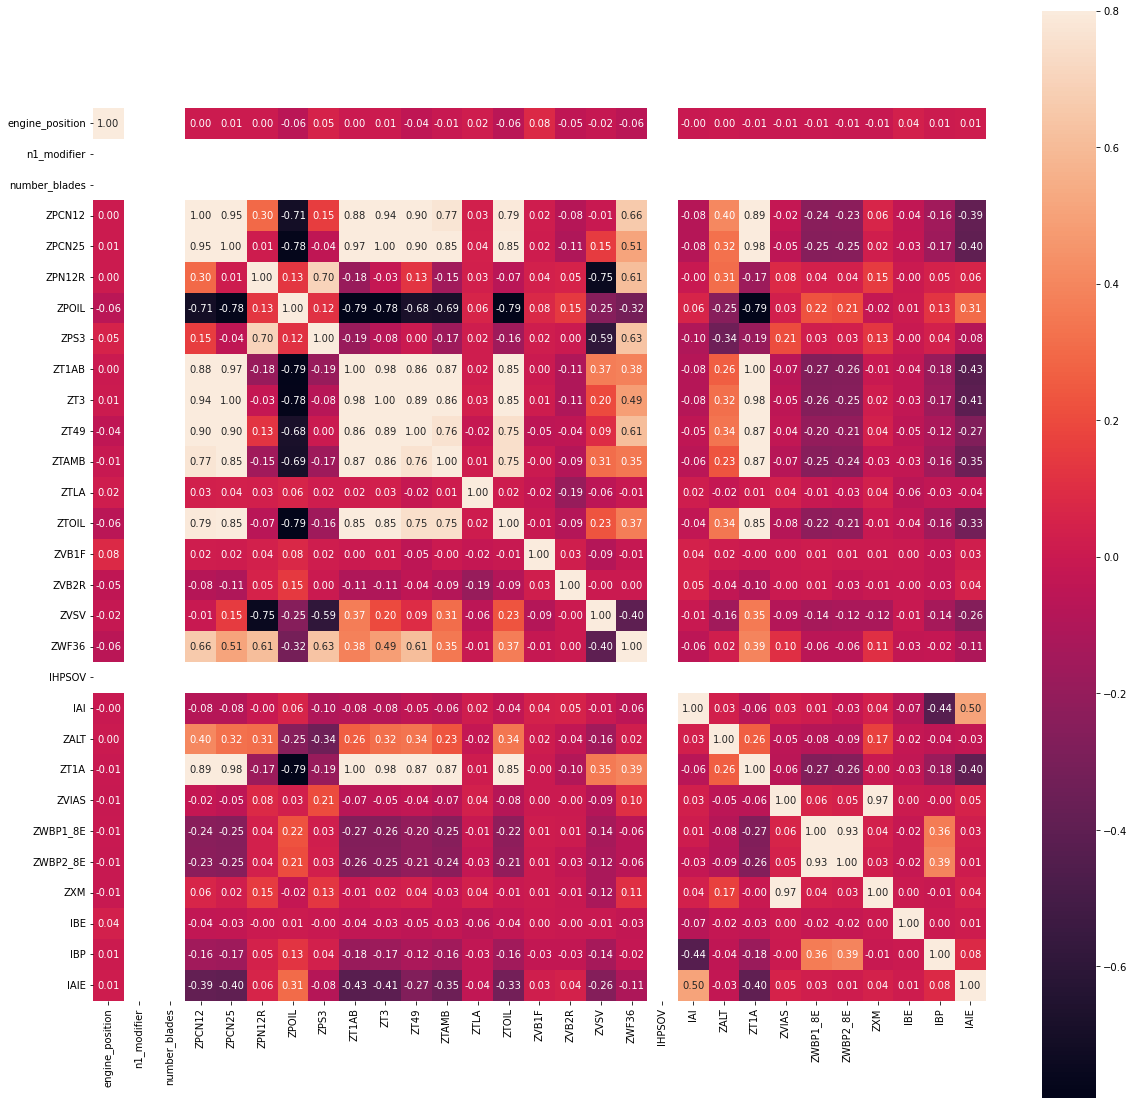

In [11]:
X_corr = X_valid_0
corrmat = X_corr.merge(X_corr).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

In [12]:
X_corr.drop(["ZT1AB", "ZT49", "ZTAMB", "ZPCN12", "ZPCN25", "ZTLA", "ZT1A", "ZPOIL", "ZTOIL"], axis = 1, inplace = True) # ZP3
X_corr.drop(["ZWBP2_8E"], axis = 1, inplace = True) #ZWBP1_8E
X_corr.drop(["ZVIAS"], axis = 1, inplace = True) #ZXM
X_corr.drop(["ZPN12R"], axis = 1, inplace = True) #ZSV
X_corr.drop(["engine_position", "n1_modifier", "number_blades", "IHPSOV"], axis = 1, inplace = True)

<AxesSubplot:>

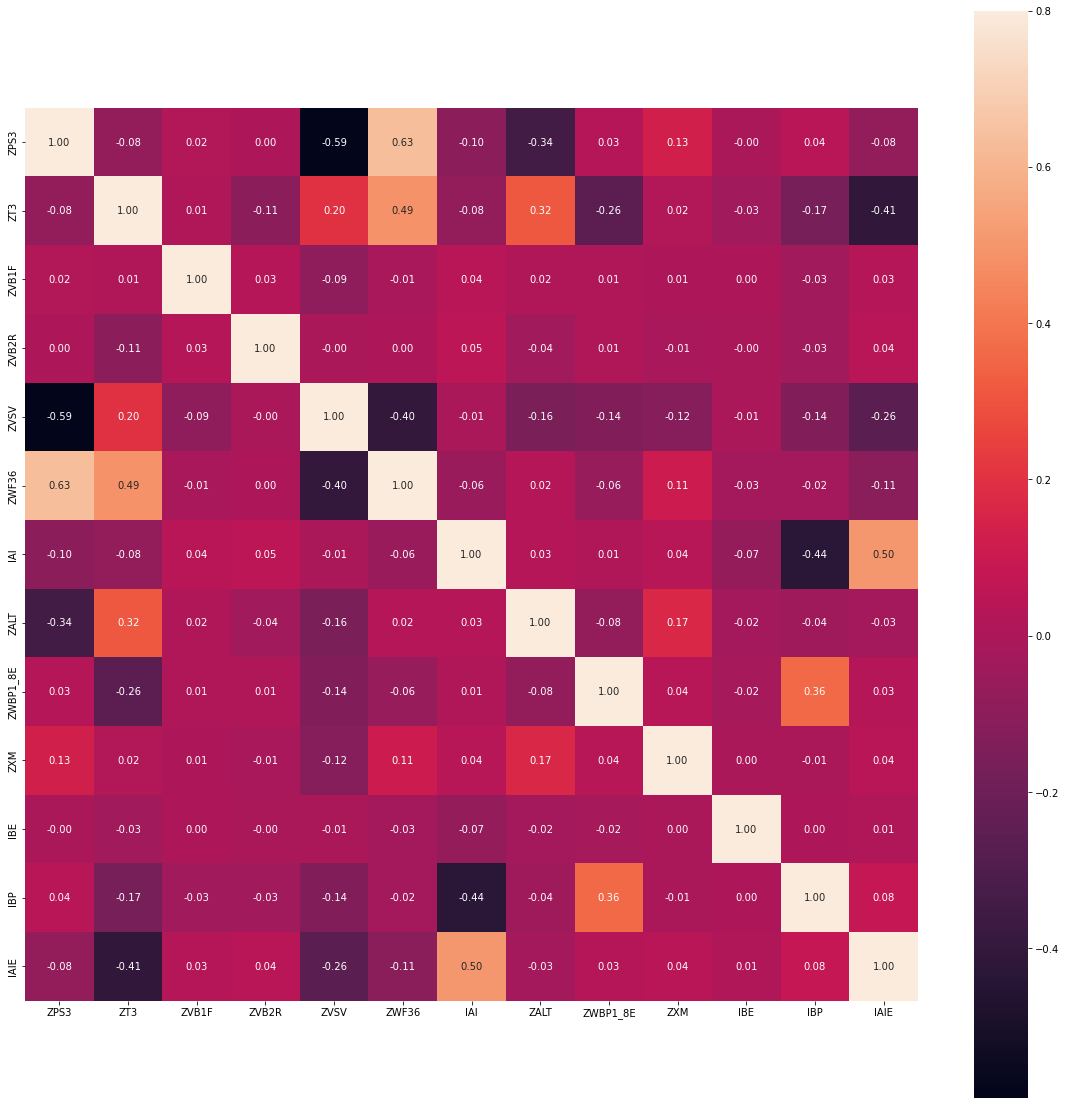

In [13]:
corrmat = X_corr.merge(X_corr).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

In [6]:
X_train = pd.read_csv(r"X_train.csv")
X_train["type"] = X_train["flight_phase"] + " "+ X_train["engine_type"]
nan_valid_matrix = nan_percent_table(X_train, 'type')
nan_valid_matrix

TAKEOFF CFM56-5B4 CRUISE CF34-8E5 CRUISE CFM56-5B4  \
ZHPTAC                 0.0             0.0              1.0   
ZLPTAC                 0.0             0.0              1.0   
ZPHSF                  1.0             0.0         0.999399   
ZPHSR                  1.0             0.0         0.999399   
ZPN12R                 0.0         0.99989              0.0   
ZPOIL                  0.0             1.0              1.0   
ZPS3                   0.0         0.99989              0.0   
ZT1AB                  0.0         0.99989              0.0   
ZT3                    0.0         0.99989              0.0   
ZTAMB                  0.0             1.0              0.0   
ZTLA                   0.0             1.0              0.0   
ZTNAC                  0.0             0.0              1.0   
ZTOIL                  0.0             1.0              1.0   
ZVB1F                  1.0             1.0         0.999399   
ZVB1R                  1.0             0.0         0.999399   
ZVB2F             0.998036             0.0         0.998559   
ZVB2R             0.998036             1.0         0.998559   
ZVSV                   0.0         0.99989              1.0   
ZWF36                  0.0             1.0              1.0   
IHPSOV                 0.0             1.0              0.0   
AGW                    1.0             0.0              1.0   
CAS                    1.0             0.0              1.0   
IAI                    1.0             0.0              0.0   
IVS12                  1.0             0.0              1.0   
SAT                    0.0             0.0              0.0   
ZVIAS                  0.0         0.99989              0.0   
ZWBP1                  1.0             0.0              1.0   
ZWBP1_8E               0.0             1.0              0.0   
ZWBP2                  1.0             0.0              1.0   
ZWBP2_8E               0.0             1.0              0.0   
IBP                    0.0             1.0              0.0   
IAIE                   1.0             1.0              0.0   

         CRUISE CFM56-7B27/B1 TAKEOFF CFM56-7B26 TAKEOFF CF34-8E5  \
ZHPTAC                    0.0                0.0              0.0   
ZLPTAC                    0.0                0.0              0.0   
ZPHSF                     0.0                0.0              0.0   
ZPHSR                     0.0                0.0              0.0   
ZPN12R                    0.0                0.0              1.0   
ZPOIL                     1.0                0.0              1.0   
ZPS3                      0.0                0.0         0.999893   
ZT1AB                     0.0                0.0              1.0   
ZT3                       0.0                0.0         0.999893   
ZTAMB                     0.0                0.0              1.0   
ZTLA                      0.0                0.0              1.0   
ZTNAC                     0.0                0.0              0.0   
ZTOIL                     1.0                0.0              1.0   
ZVB1F                     1.0                1.0              1.0   
ZVB1R                     0.0                1.0              0.0   
ZVB2F                     0.0                1.0              0.0   
ZVB2R                     0.0                1.0              1.0   
ZVSV                      0.0                0.0         0.999893   
ZWF36                     1.0                0.0              1.0   
IHPSOV                    0.0                0.0              1.0   
AGW                       1.0                1.0              0.0   
CAS                       0.0                1.0              0.0   
IAI                       0.0                1.0         0.999893   
IVS12                     1.0                1.0              0.0   
SAT                       1.0                1.0              0.0   
ZVIAS                     0.0                0.0         0.999893   
ZWBP1                     0.0                0.0              0.0 

In [7]:
def cleaning_train(i):
    X_valid_i = X_train[X_train["type"] == nan_valid_matrix.columns[i]]
    nan_valid_matrix_i = nan_valid_matrix[nan_valid_matrix.columns[i]]
    for j in nan_valid_matrix.index:
        if nan_valid_matrix_i[j] == 0:
            X_valid_i = X_valid_i.drop(j, axis = 1)
        else:
            X_valid_i[j].fillna(X_valid_i[j].median(), inplace = True)
    return X_valid_i

In [8]:
X_train_0 = cleaning_train(0)
X_train_1 = cleaning_train(1)
X_train_2 = cleaning_train(2)
X_train_3 = cleaning_train(3)
X_train_4 = cleaning_train(4)
X_train_5 = cleaning_train(5)
X_train_6 = cleaning_train(6)
X_train_7 = cleaning_train(7)
X_train_8 = cleaning_train(8)
X_train_9 = cleaning_train(9)

C:\Users\kiril\AppData\Local\Temp\ipykernel_11700\1235845376.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_i[j].fillna(X_valid_i[j].median(), inplace = True)
C:\Users\kiril\AppData\Local\Temp\ipykernel_11700\1235845376.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_i[j].fillna(X_valid_i[j].median(), inplace = True)


<AxesSubplot:>

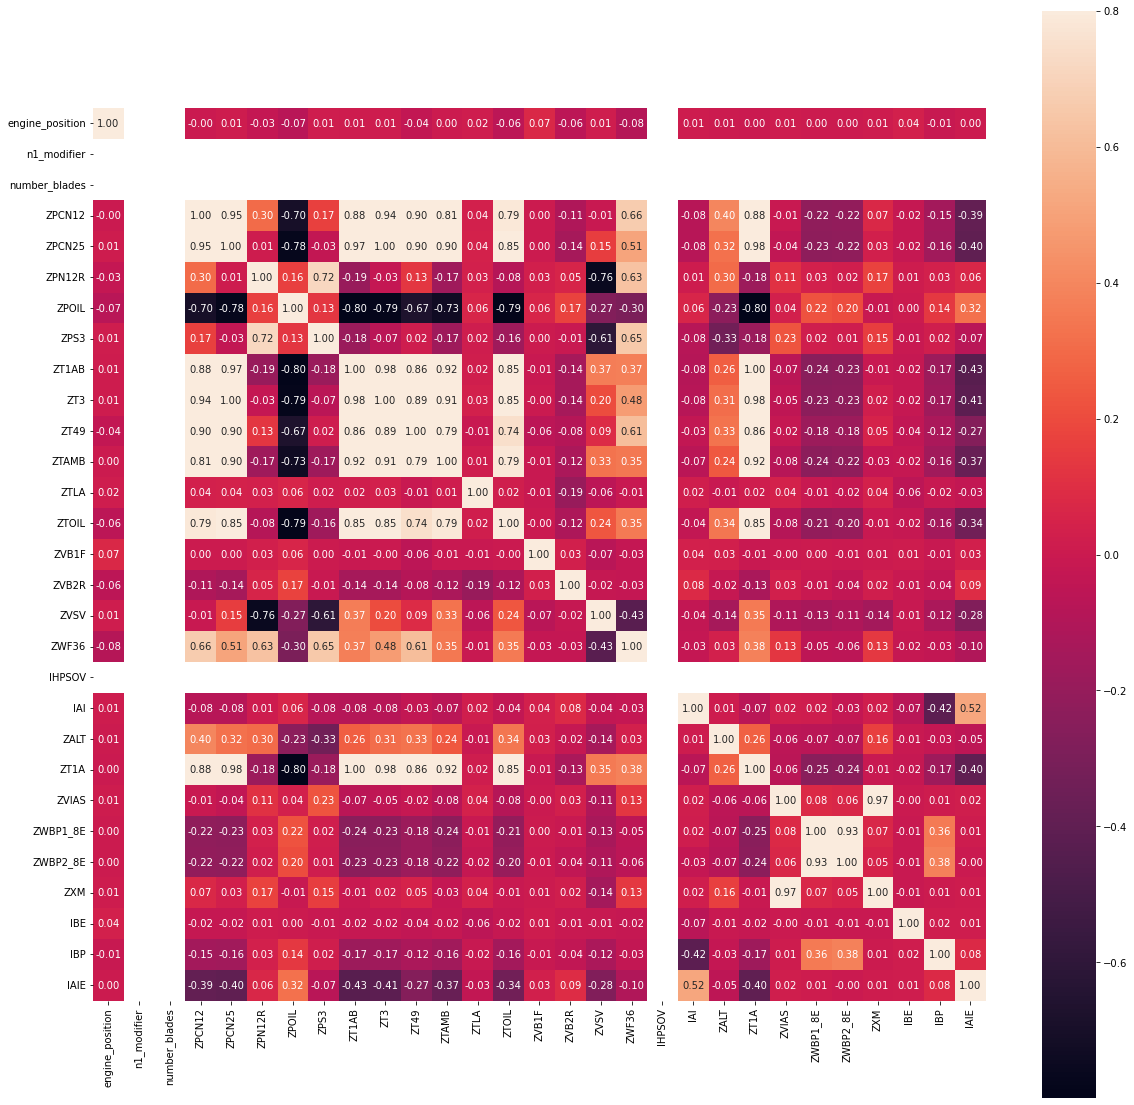

In [17]:
X_corr_5 = X_train_5
corrmat = X_corr_5.merge(X_corr_5).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

In [18]:
X_corr_5.drop(["ZT1AB", "ZT49", "ZTAMB", "ZPCN12", "ZPCN25", "ZTLA", "ZT1A", "ZPOIL", "ZTOIL"], axis = 1, inplace = True) # ZP3
X_corr_5.drop(["ZWBP2_8E"], axis = 1, inplace = True) #ZWBP1_8E
X_corr_5.drop(["ZVIAS"], axis = 1, inplace = True) #ZXM
X_corr_5.drop(["ZPN12R"], axis = 1, inplace = True) #ZSV
X_corr_5.drop(["engine_position", "n1_modifier", "number_blades", "IHPSOV"], axis = 1, inplace = True)

<AxesSubplot:>

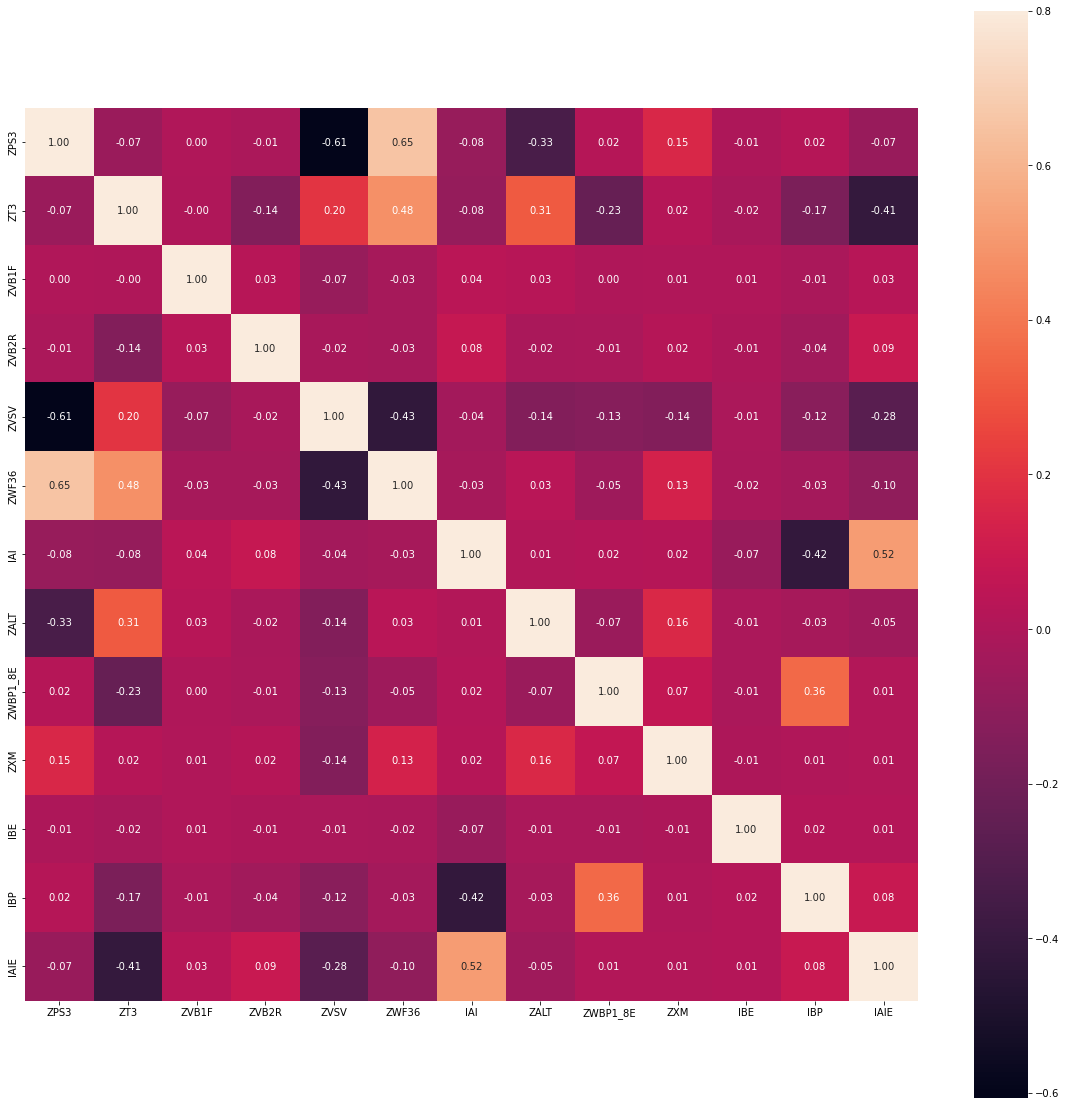

In [19]:
corrmat = X_corr_5.merge(X_corr_5).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

<AxesSubplot:>

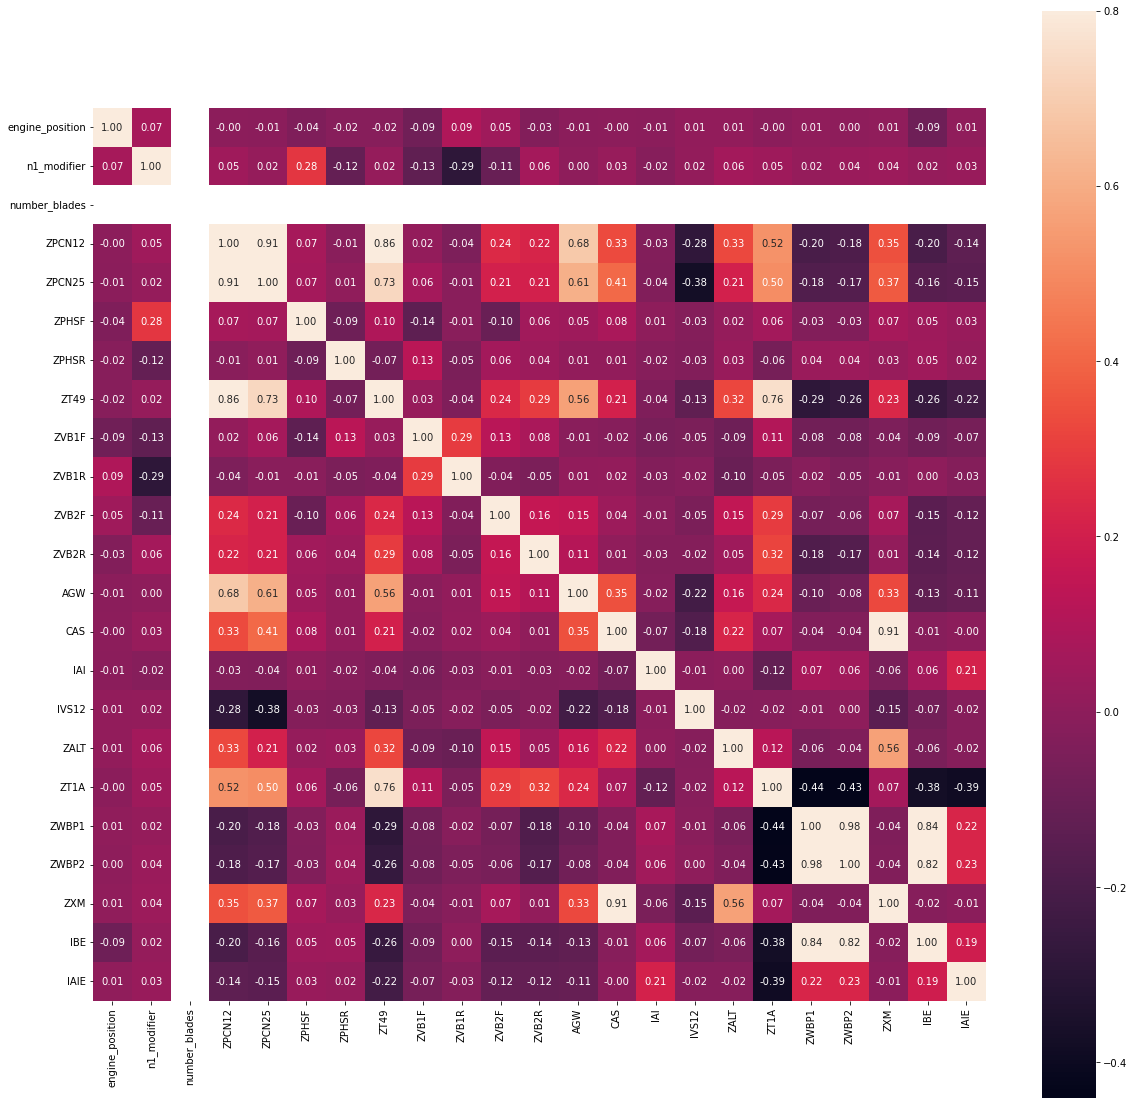

In [20]:
X_corr_0 = X_train_0
corrmat = X_corr_0.merge(X_corr_0).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

In [21]:
X_corr_0.drop(["ZT49", "ZPCN25"], axis = 1, inplace = True) # ZPCN12
X_corr_0.drop(["ZXM"], axis = 1, inplace = True) # CAS
X_corr_0.drop(["ZWBP2", "IBE"], axis = 1, inplace = True) # ZWBP2
X_corr_0.drop(["engine_position", "n1_modifier", "number_blades"], axis = 1, inplace = True)

<AxesSubplot:>

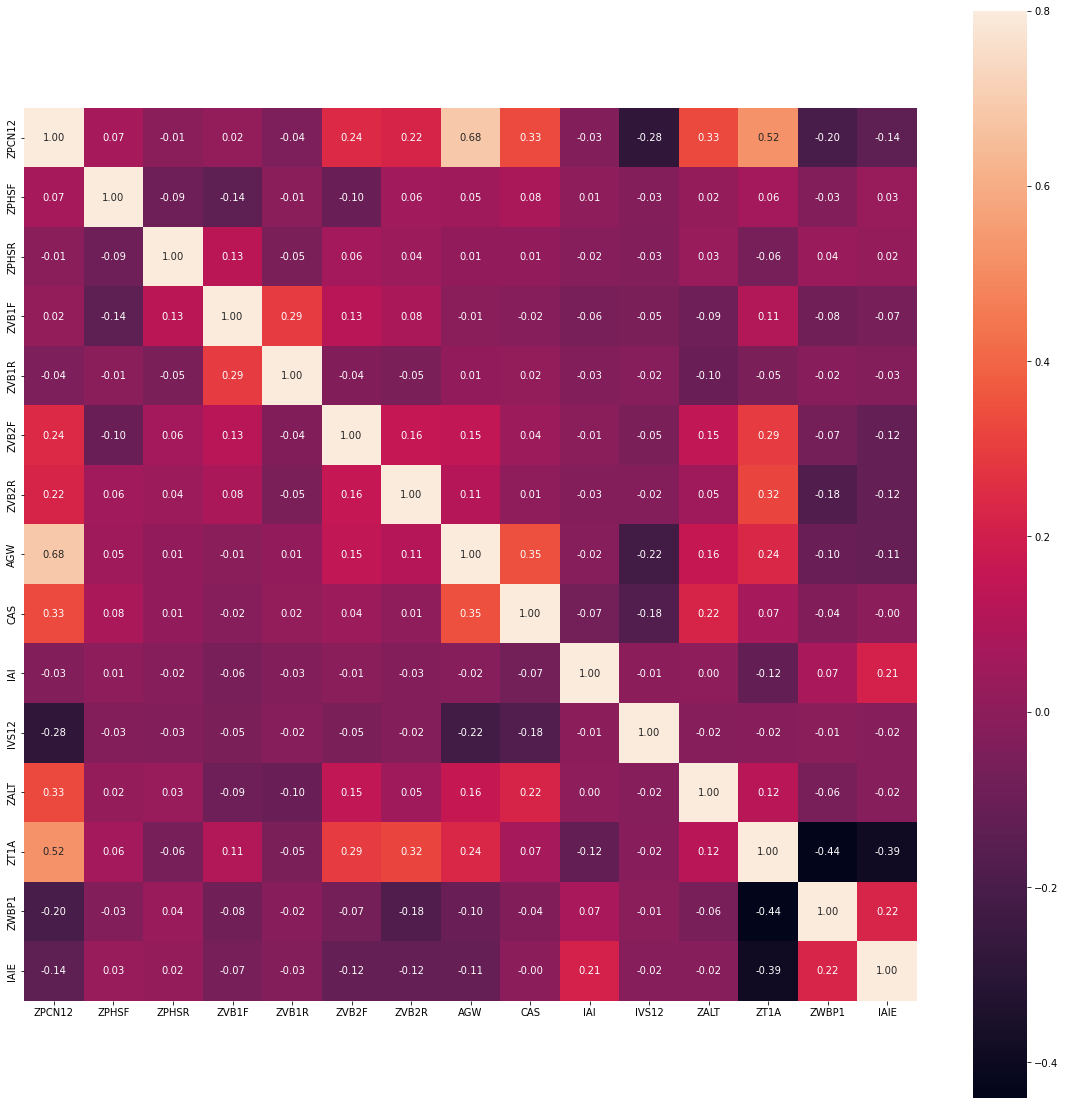

In [22]:
corrmat = X_corr_0.merge(X_corr_0).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

<AxesSubplot:>

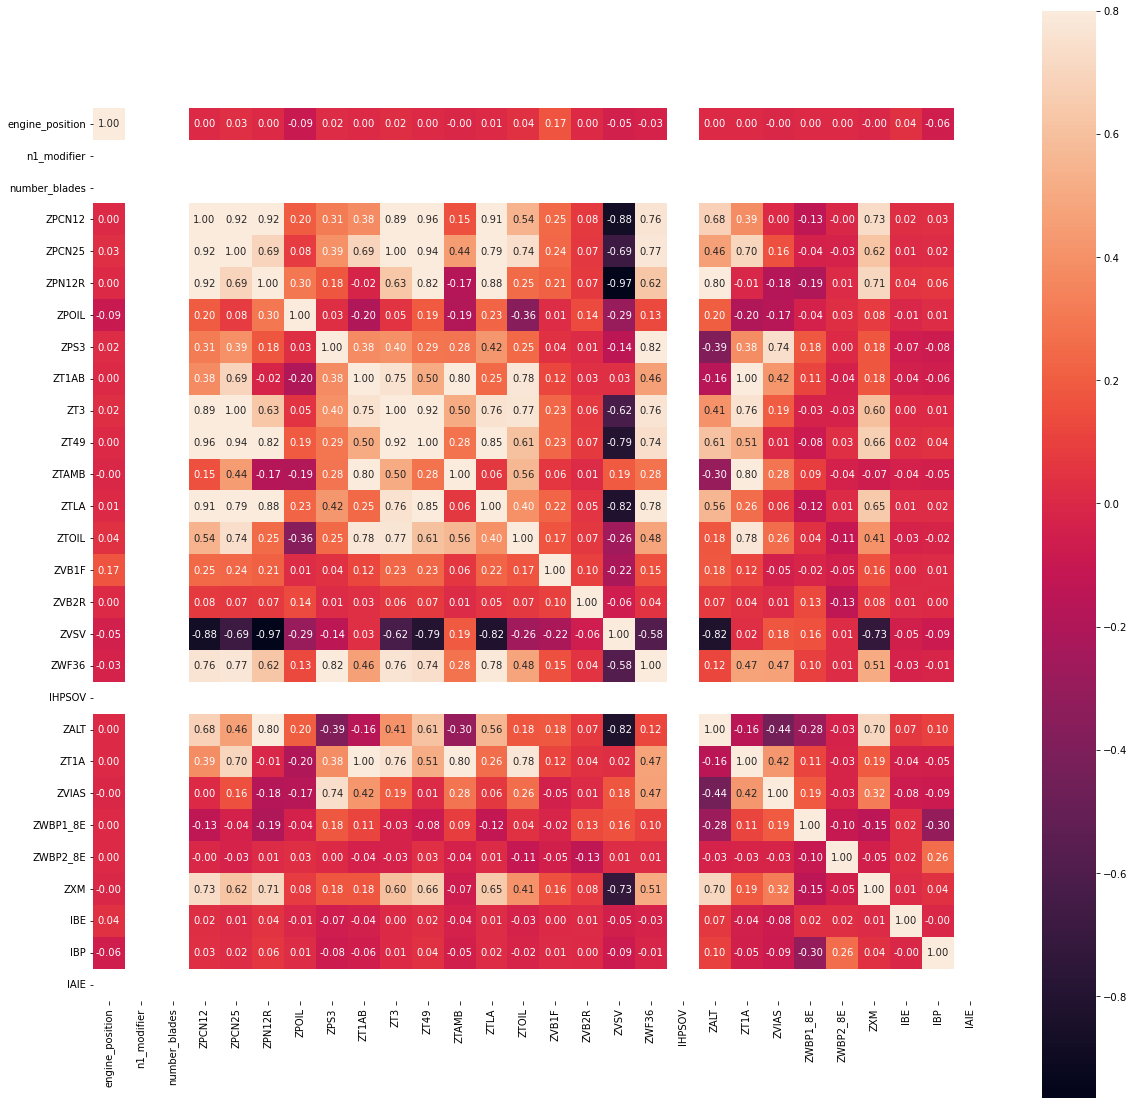

In [23]:
X_corr_1 = X_train_1
corrmat = X_corr_1.merge(X_corr_1).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

In [24]:
X_corr_1.drop(["ZT1AB", "ZT49", "ZTAMB", "ZPN12R", "ZPCN12", "ZPCN25", "ZTLA", "ZT1A", "ZTOIL", "ZWF36"], axis = 1, inplace = True) # ZP3
X_corr_1.drop(["ZXM", "ZPS3", "ZVSV"], axis = 1, inplace = True) #ZVIAS
X_corr_1.drop(["engine_position", "n1_modifier", "number_blades", "IHPSOV"], axis = 1, inplace = True)

<AxesSubplot:>

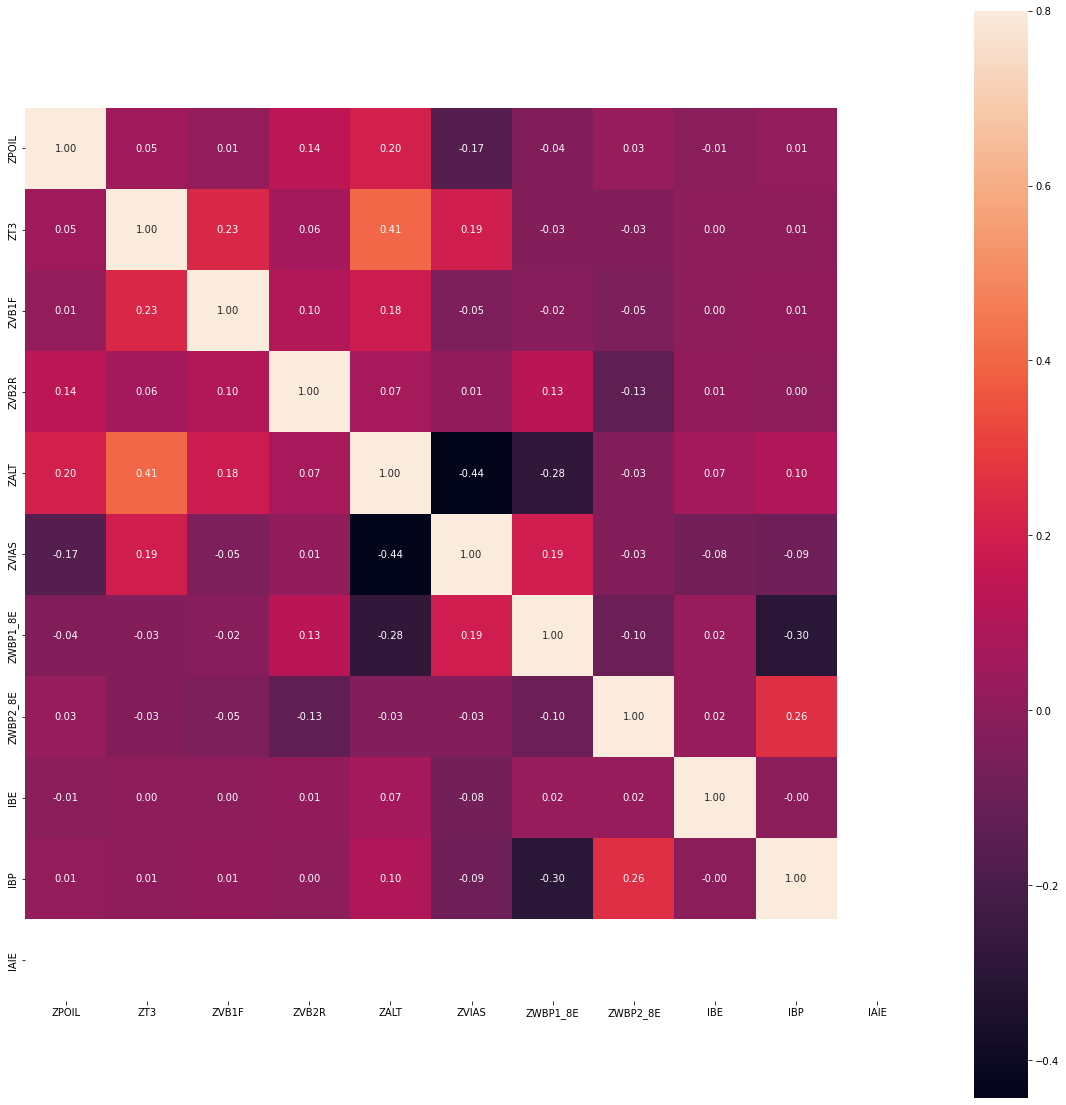

In [25]:
corrmat = X_corr_1.merge(X_corr_1).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

<AxesSubplot:>

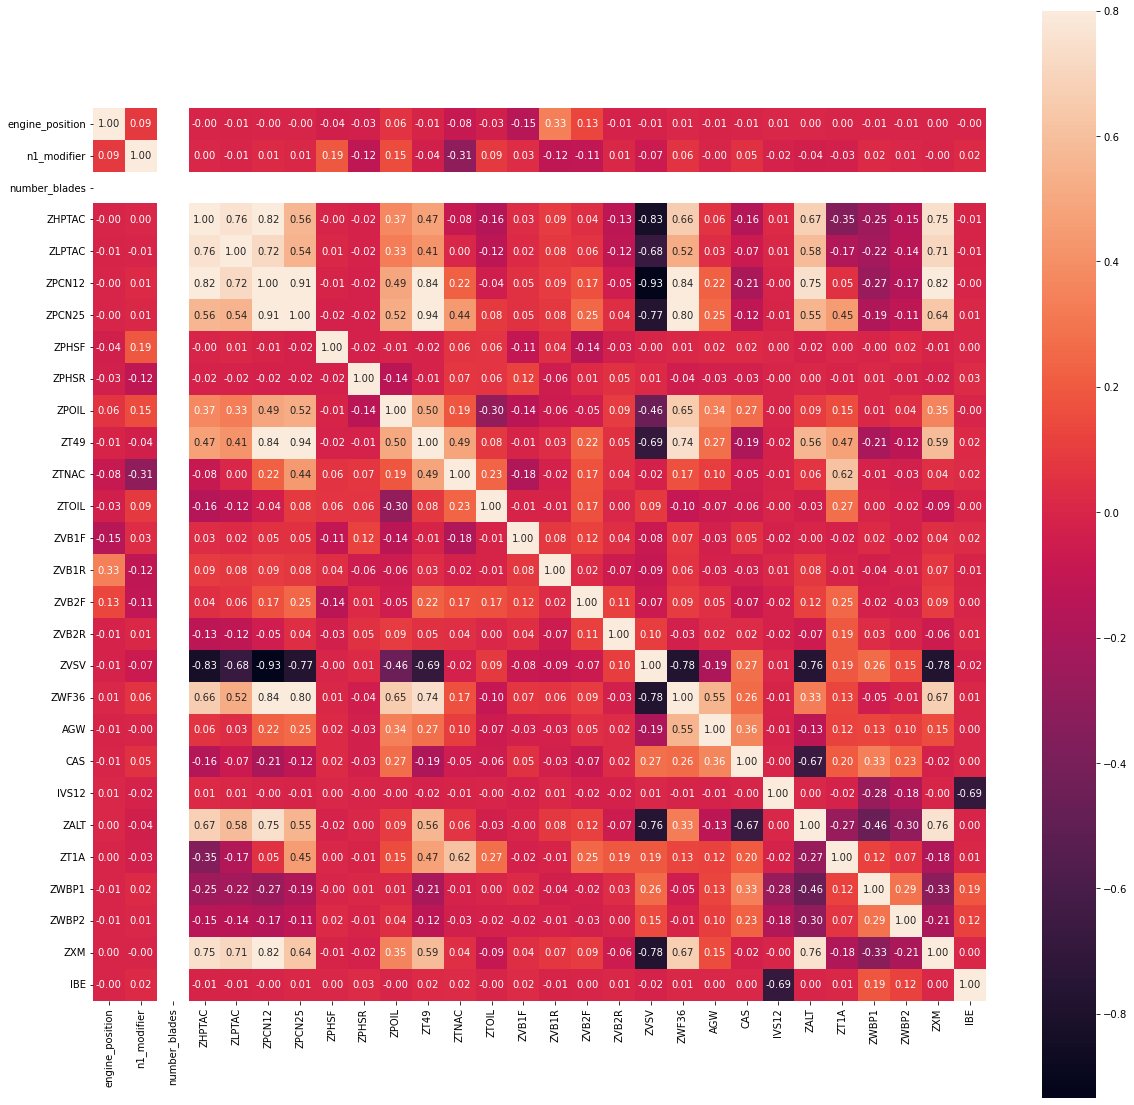

In [26]:
X_corr_2 = X_train_2
corrmat = X_corr_2.merge(X_corr_2).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

In [27]:
X_corr_2.drop(["ZHPTAC", "ZT49", "ZLPTAC", "ZPCN25", "ZVSV", "ZALT", "ZWF36", "ZXM"], axis = 1, inplace = True) # ZPCN12

X_corr_2.drop(["engine_position", "n1_modifier", "number_blades"], axis = 1, inplace = True)

<AxesSubplot:>

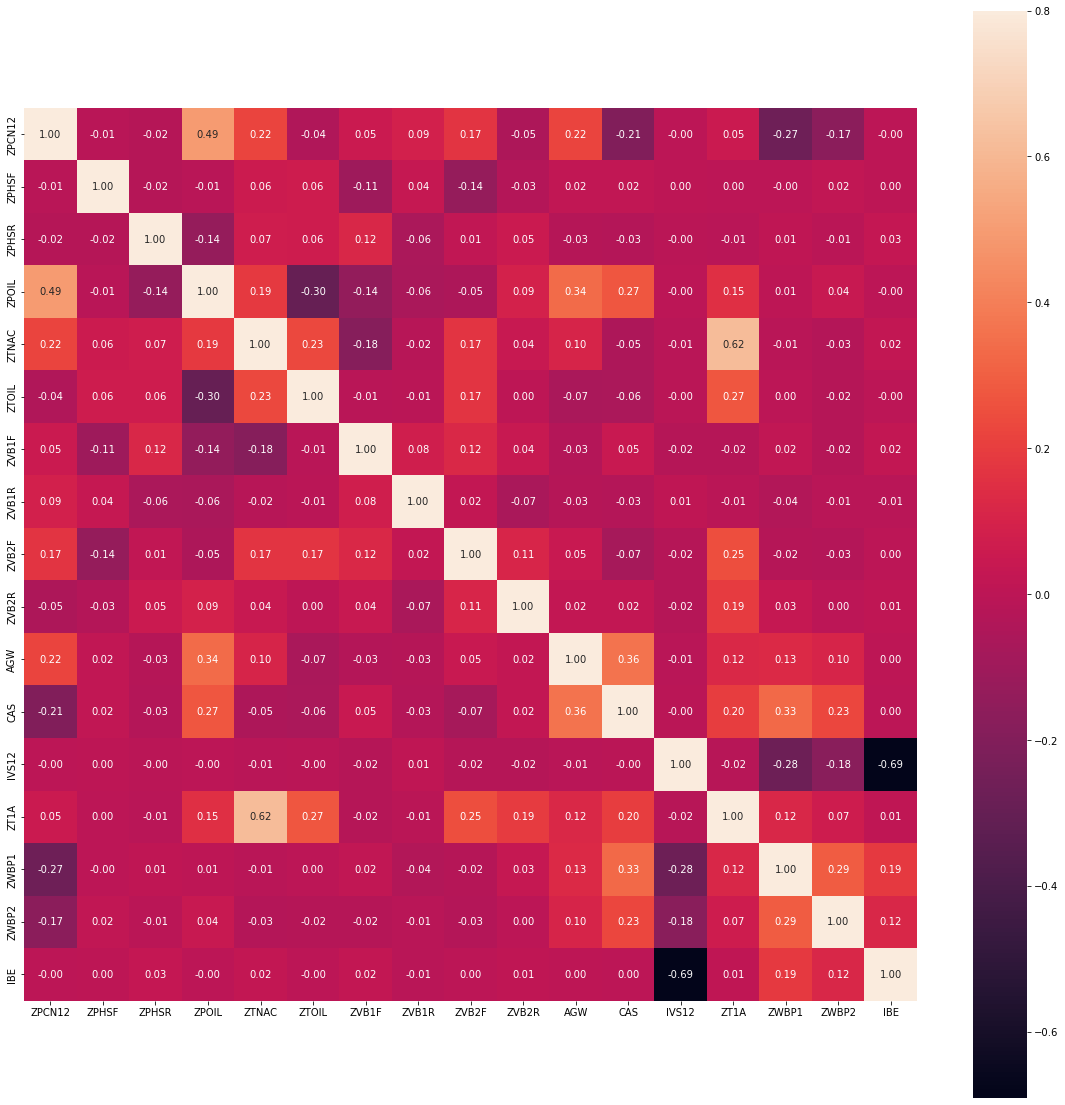

In [28]:
corrmat = X_corr_2.merge(X_corr_2).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

<AxesSubplot:>

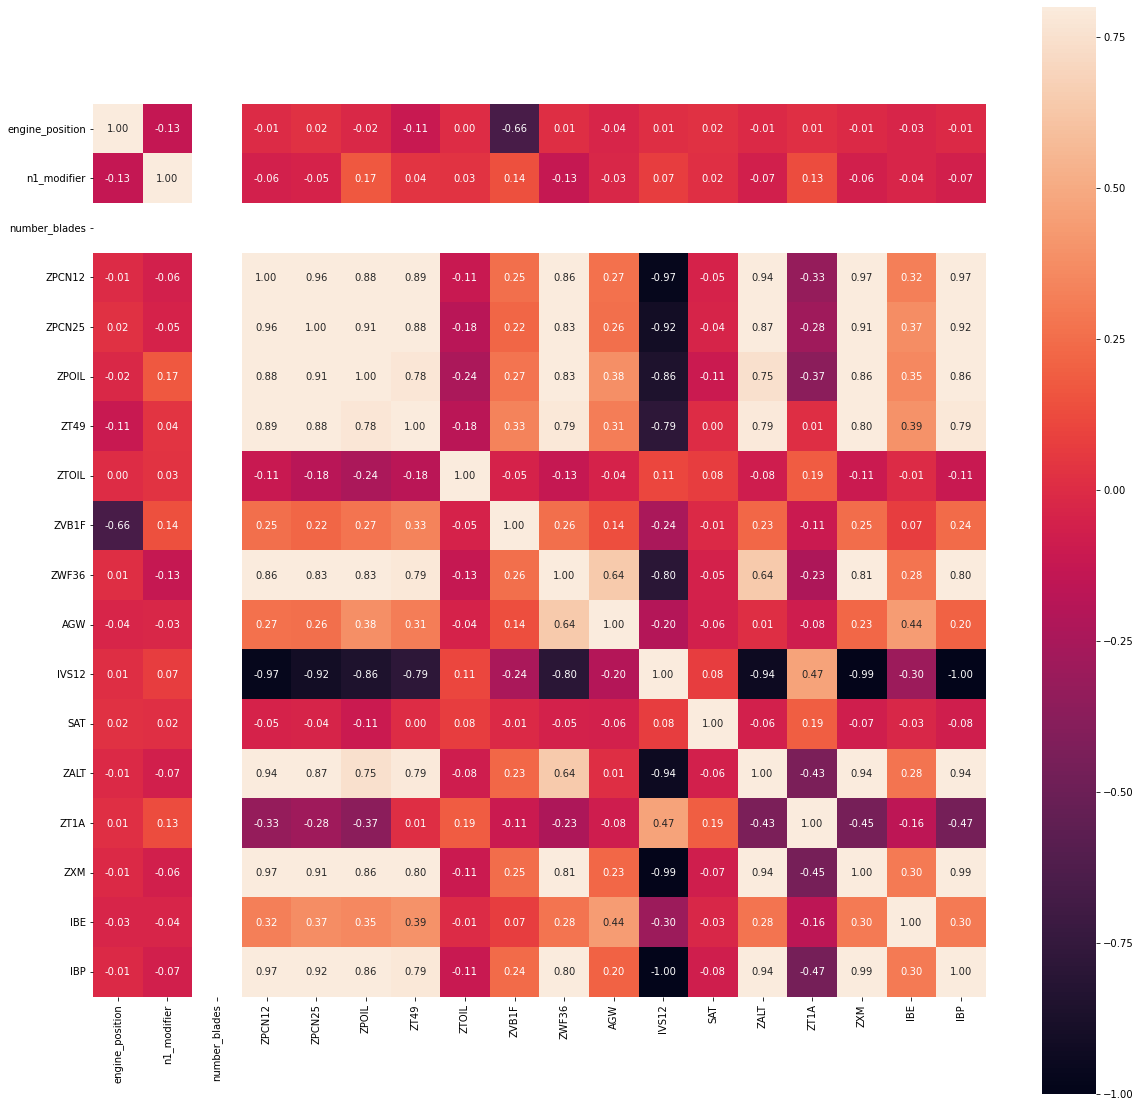

In [29]:
X_corr_3 = X_train_3
corrmat = X_corr_3.merge(X_corr_3).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

In [30]:
X_corr_3.drop(["ZPCN12", "ZPOIL", "ZT49", "ZWF36", "IVS12", "ZALT", "ZXM", "IBP"], axis = 1, inplace = True) # ZPCN25

X_corr_3.drop(["engine_position", "n1_modifier", "number_blades"], axis = 1, inplace = True)

<AxesSubplot:>

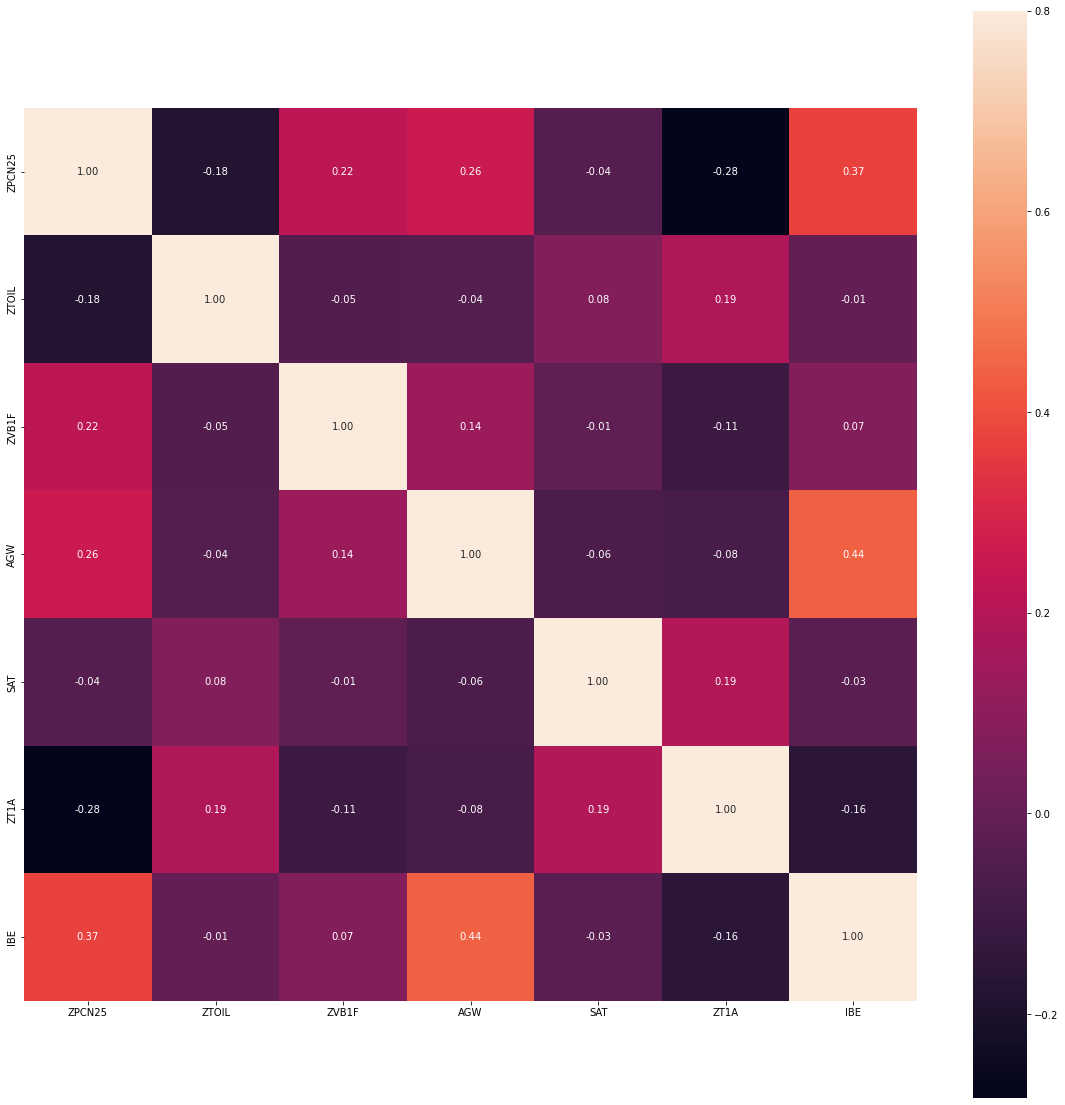

In [31]:
corrmat = X_corr_3.merge(X_corr_3).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

<AxesSubplot:>

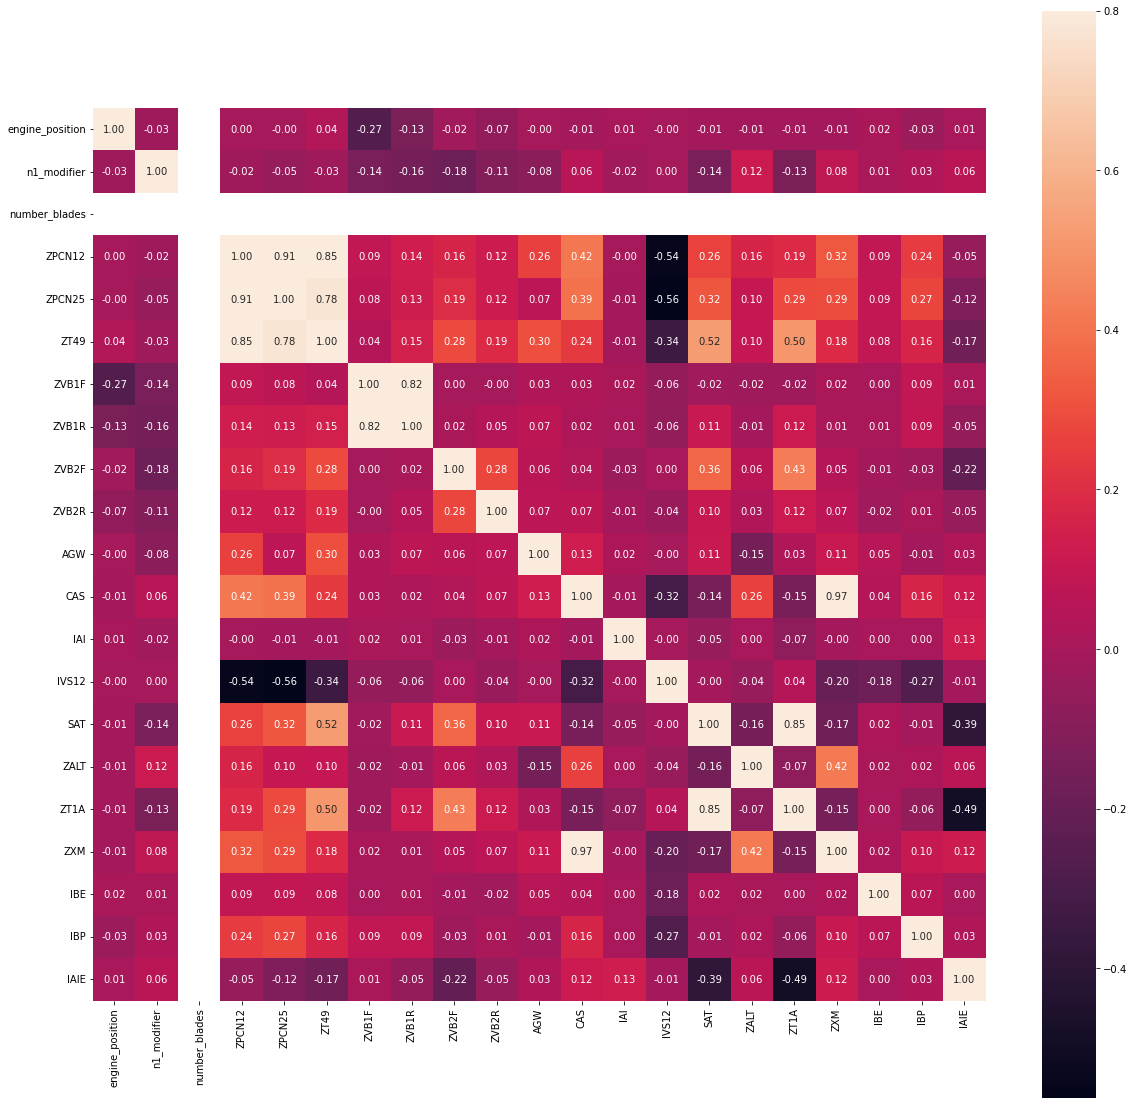

In [32]:
X_corr_4 = X_train_4
corrmat = X_corr_4.merge(X_corr_4).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

In [33]:
X_corr_4.drop(["ZPCN25", "ZT49"], axis = 1, inplace = True) # ZPCN12

X_corr_4.drop(["CAS"], axis = 1, inplace = True) # ZXM

X_corr_4.drop(["engine_position", "n1_modifier", "number_blades"], axis = 1, inplace = True)

<AxesSubplot:>

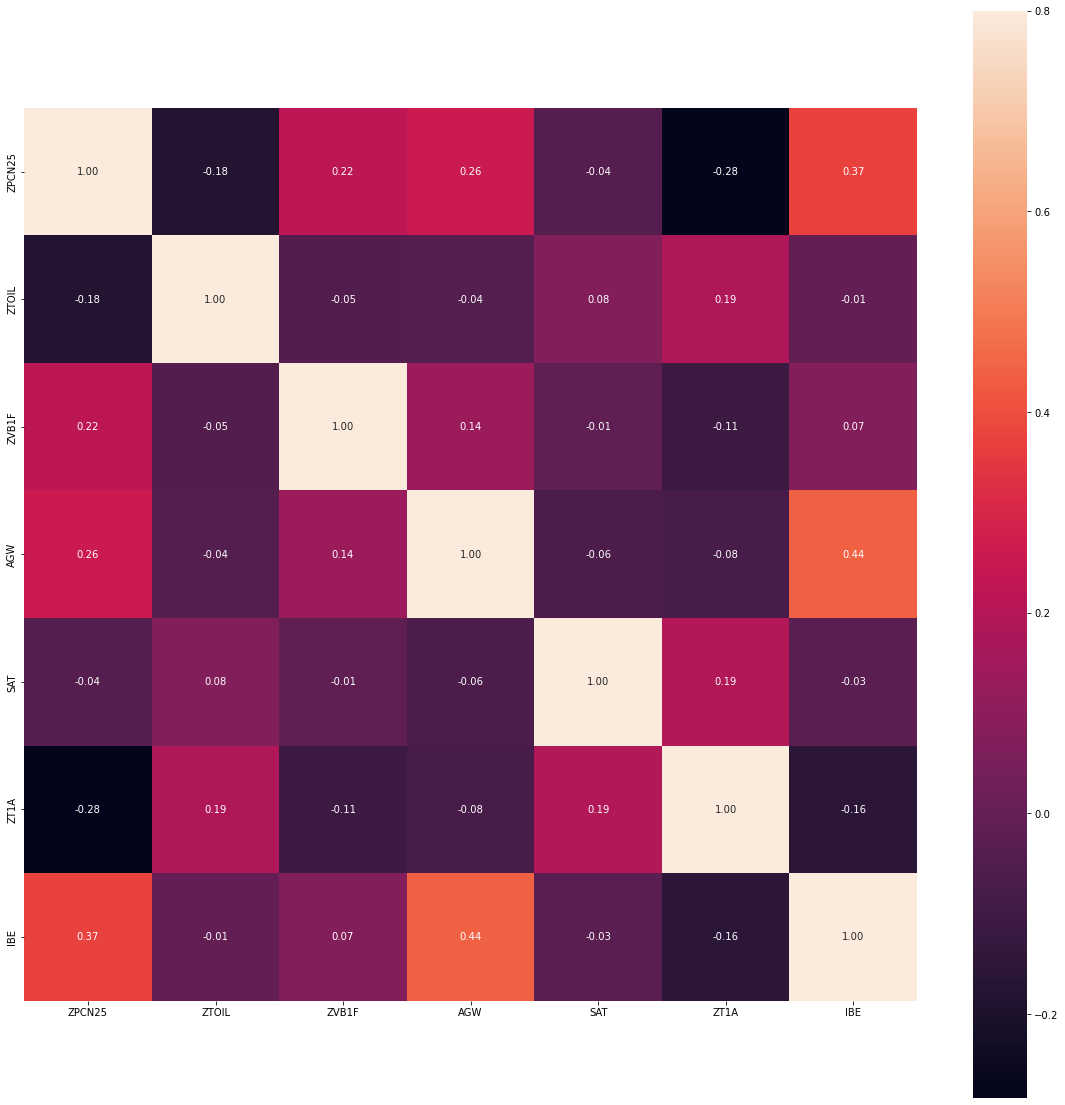

In [34]:
corrmat = X_corr_3.merge(X_corr_3).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

<AxesSubplot:>

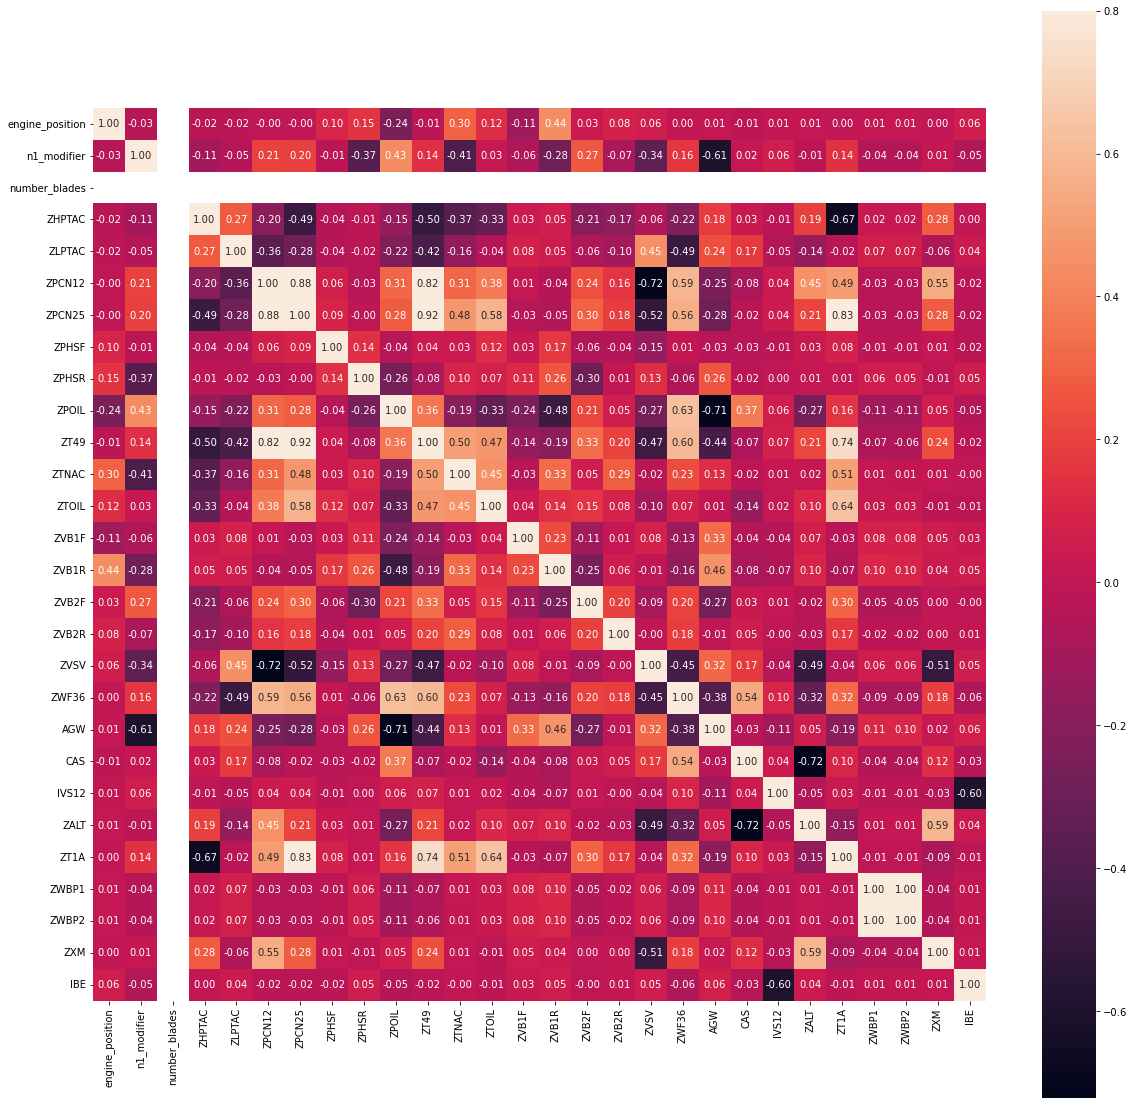

In [35]:
X_corr_6 = X_train_6
corrmat = X_corr_6.merge(X_corr_6).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

In [43]:
X_corr_6.drop(["ZPCN25", "ZT49"], axis = 1, inplace = True) # ZPCN12

X_corr_6.drop(["ZT1A", "ZALT", "ZVSV"], axis = 1, inplace = True)

X_corr_6.drop(["ZPOIL"], axis = 1, inplace = True) # AGW

X_corr_6.drop(["ZWBP2"], axis = 1, inplace = True) # ZWBP1

X_corr_6.drop(["engine_position", "n1_modifier", "number_blades"], axis = 1, inplace = True)

KeyError: "['ZT1A', 'ZALT', 'ZVSV'] not found in axis"

<AxesSubplot:>

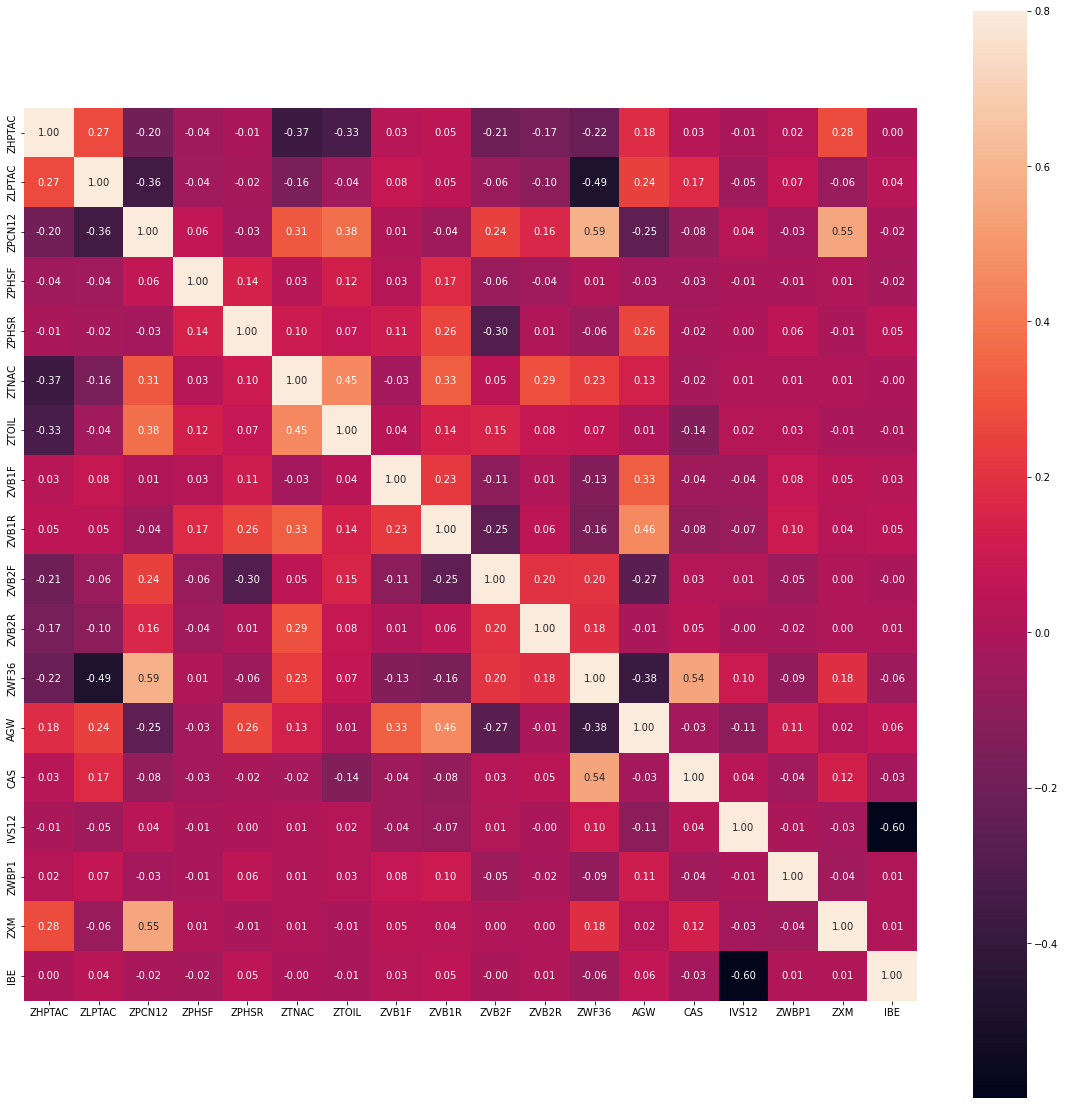

In [44]:
corrmat = X_corr_6.merge(X_corr_6).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

<AxesSubplot:>

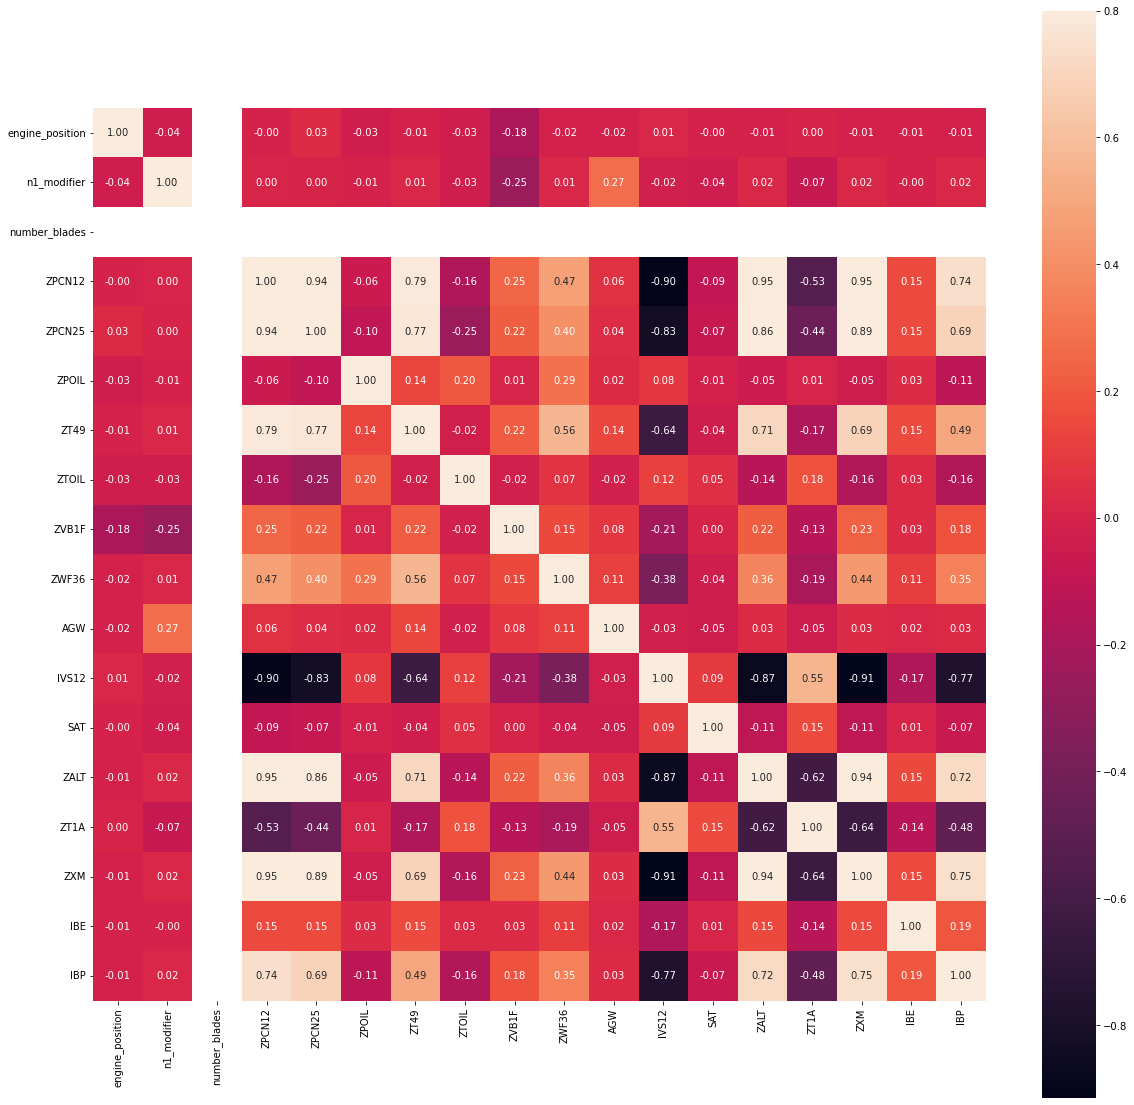

In [45]:
X_corr_7 = X_train_7
corrmat = X_corr_7.merge(X_corr_7).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

In [49]:
X_corr_7.drop(["ZPCN25", "IVS12", "ZXM", "IBP", "ZT49"], axis = 1, inplace = True) # ZPCN12

X_corr_7.drop(["ZALT", "ZT1A"], axis = 1, inplace = True)

X_corr_7.drop(["engine_position", "n1_modifier", "number_blades"], axis = 1, inplace = True)

KeyError: "['ZPCN25', 'IVS12', 'ZXM', 'IBP'] not found in axis"

<AxesSubplot:>

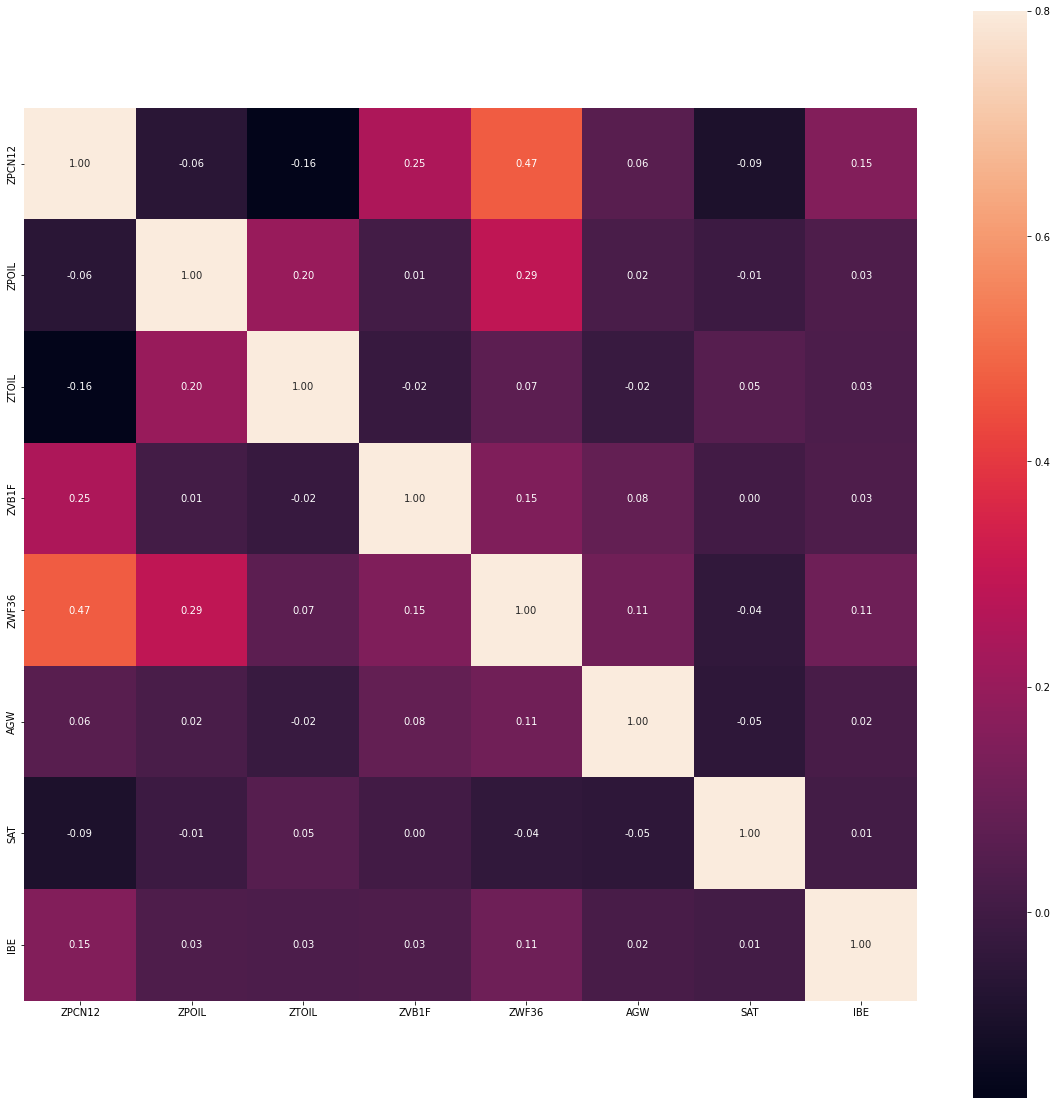

In [50]:
corrmat = X_corr_7.merge(X_corr_7).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

<AxesSubplot:>

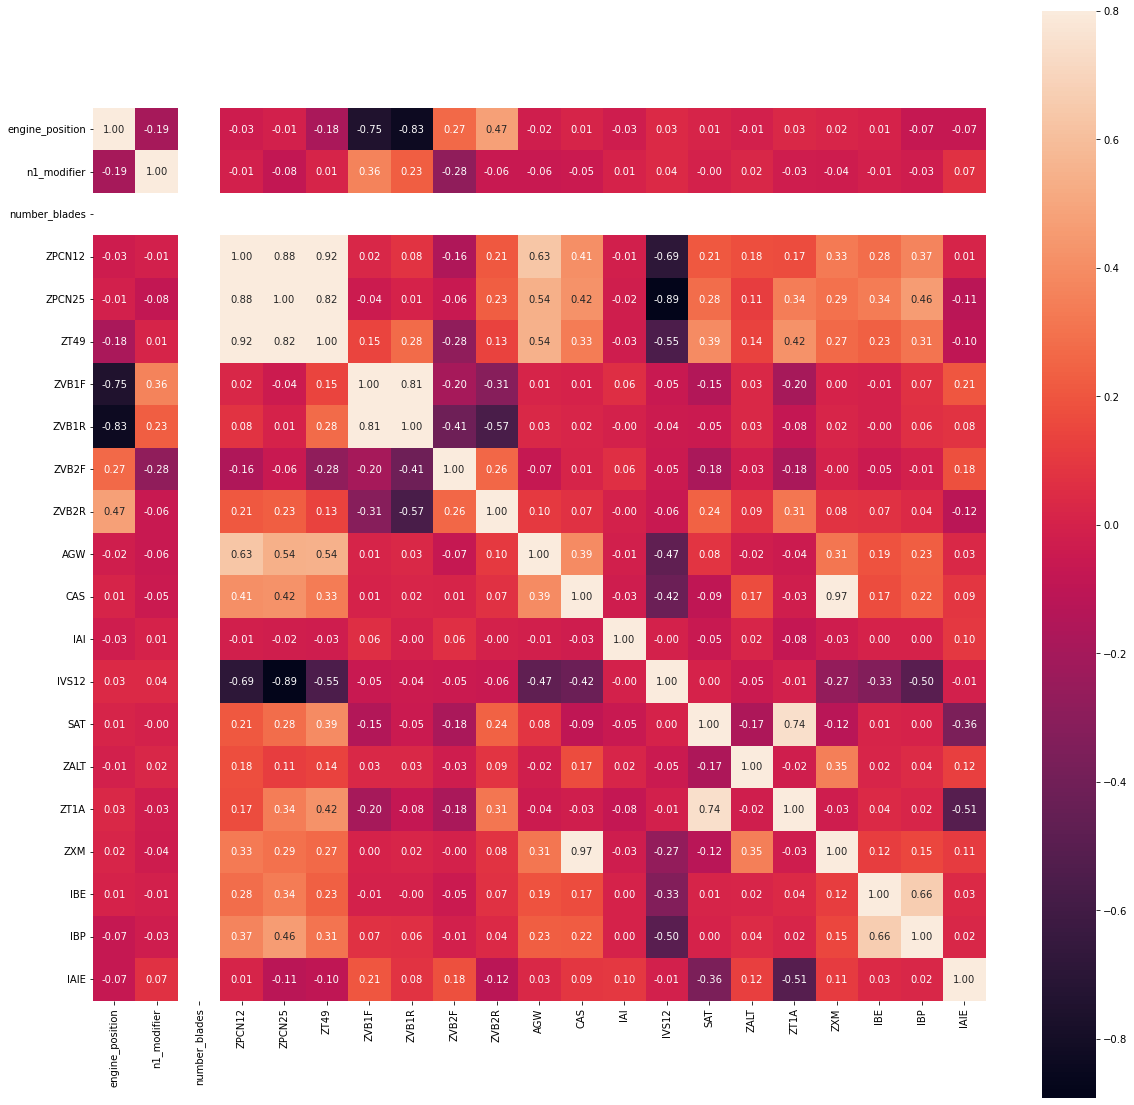

In [8]:
X_corr_8 = X_train_8
corrmat = X_corr_8.merge(X_corr_8).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

In [13]:
X_corr_8.drop(["ZVB1R"], axis = 1, inplace = True) # ZVB1F

X_corr_8.drop(["ZPCN25", "ZT49", "IVS12"], axis = 1, inplace = True) # ZPCN12

X_corr_8.drop(["CAS",], axis = 1, inplace = True) # ZXM

X_corr_8.drop(["ZALT", "ZT1A"], axis = 1, inplace = True)

X_corr_8.drop(["engine_position", "n1_modifier", "number_blades"], axis = 1, inplace = True)

KeyError: "['ZVB1R'] not found in axis"

<AxesSubplot:>

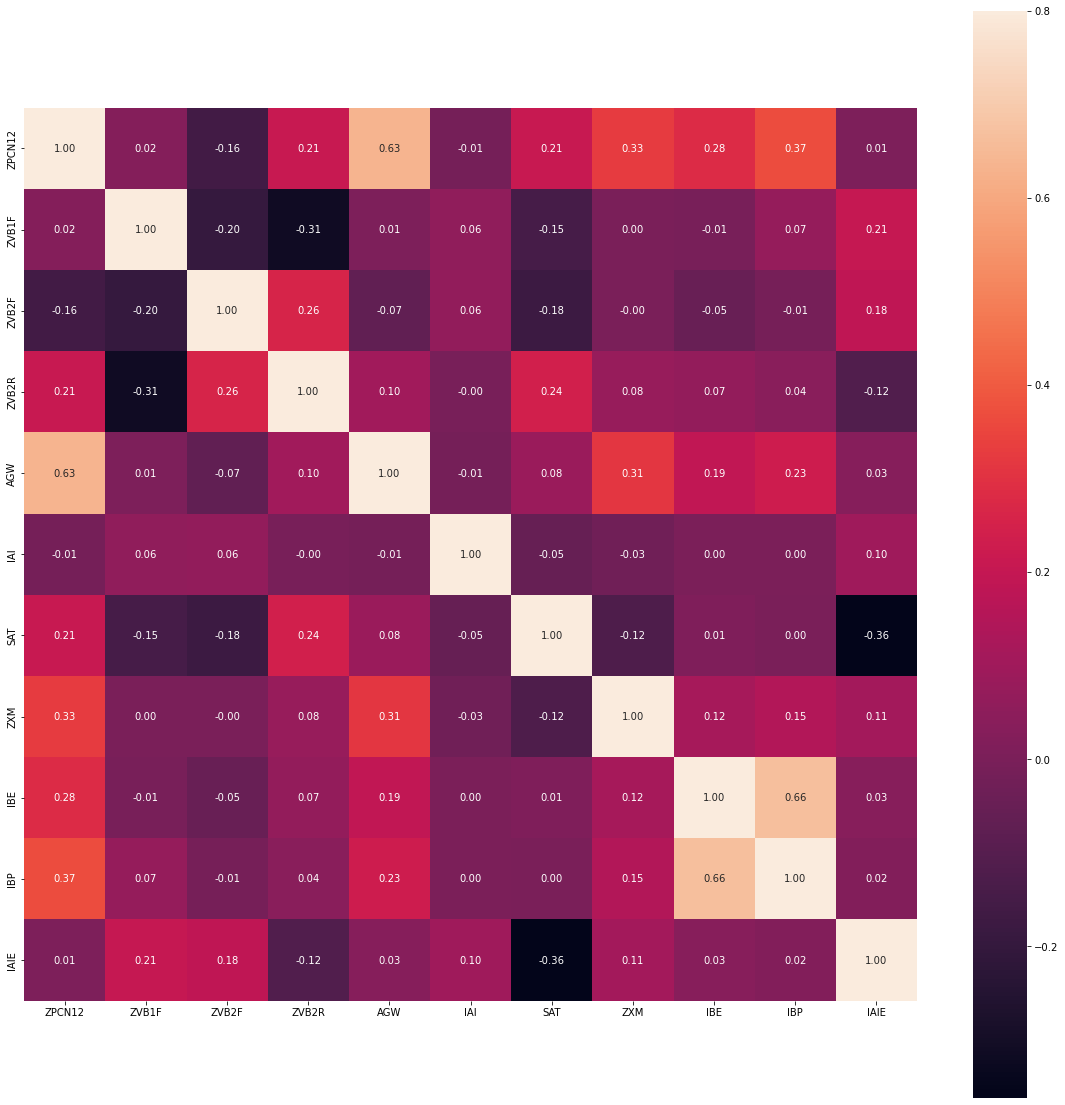

In [14]:
corrmat = X_corr_8.merge(X_corr_8).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

<AxesSubplot:>

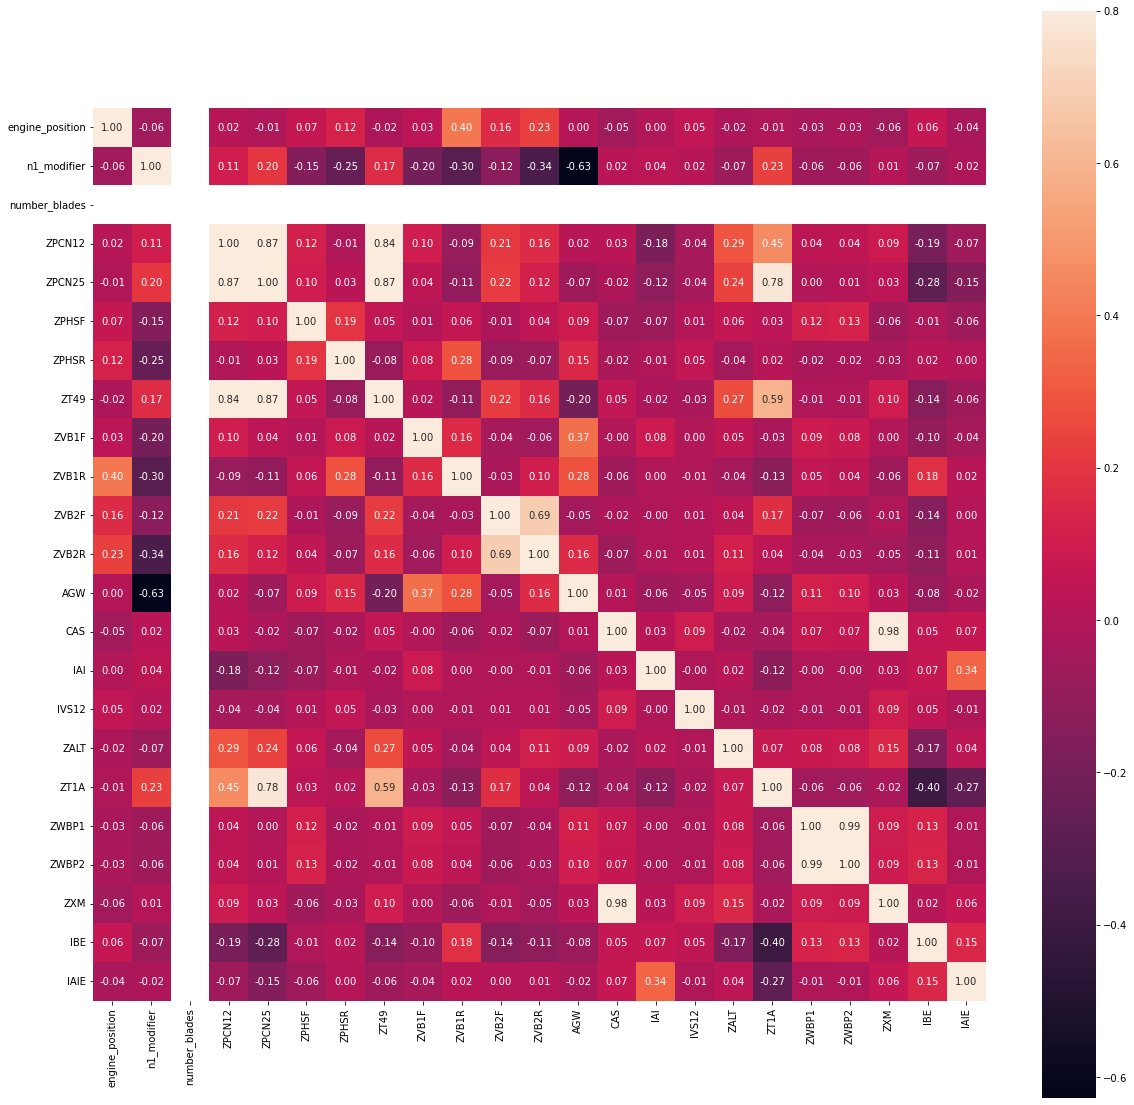

In [9]:
X_corr_9 = X_train_9
corrmat = X_corr_9.merge(X_corr_9).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

In [11]:
X_corr_9.drop(["ZVB2F"], axis = 1, inplace = True) # ZVB2R

X_corr_9.drop(["ZPCN12", "ZT49"], axis = 1, inplace = True) # ZPCN25

X_corr_9.drop(["ZALT", "ZT1A"], axis = 1, inplace = True)

X_corr_9.drop(["ZXM"], axis = 1, inplace = True) # CAS

X_corr_9.drop(["ZWBP2"], axis = 1, inplace = True) # ZWBP1

X_corr_9.drop(["engine_position", "n1_modifier", "number_blades"], axis = 1, inplace = True)

<AxesSubplot:>

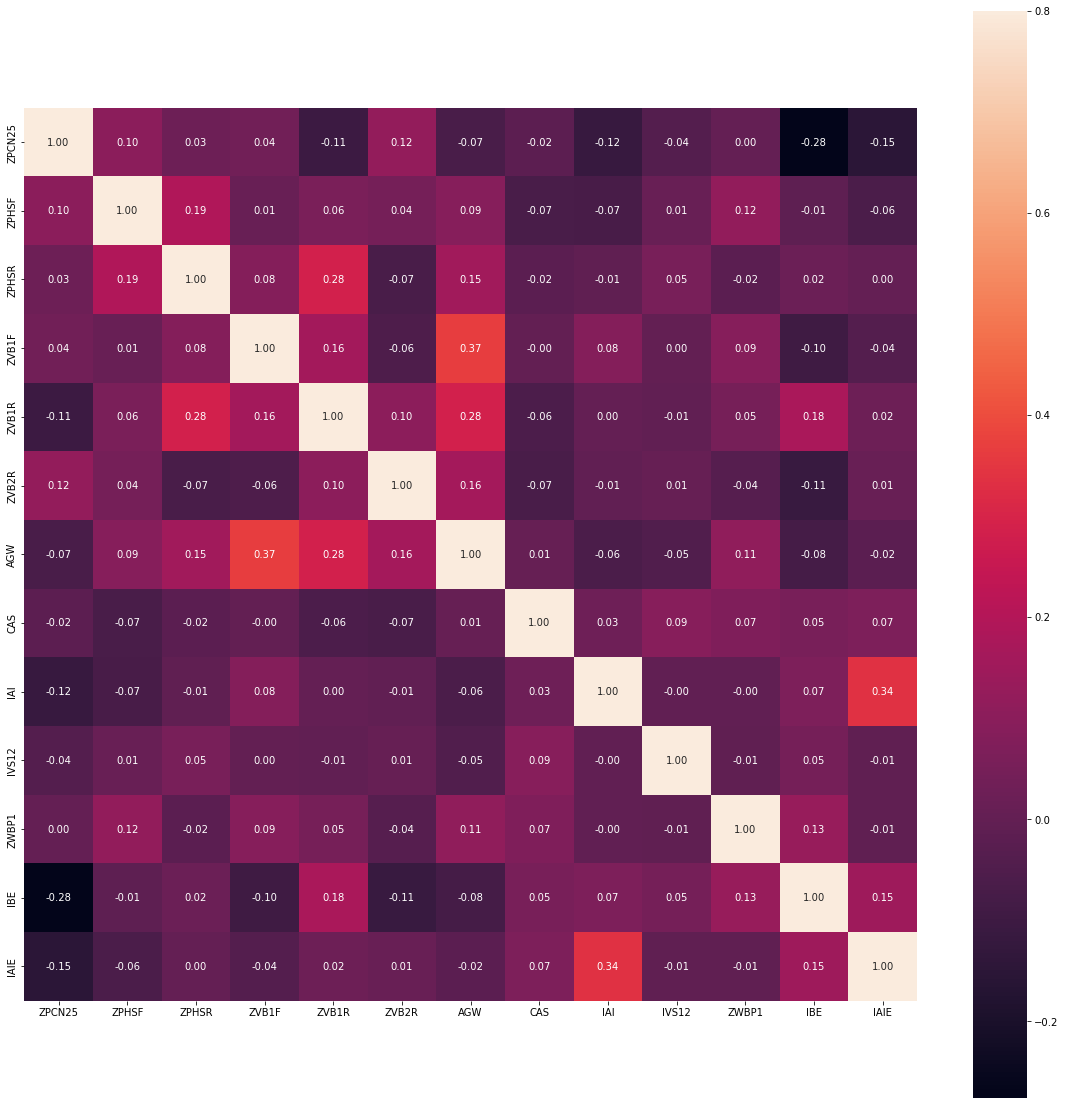

In [12]:
corrmat = X_corr_9.merge(X_corr_9).corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

In [ ]:
def RMSE(y_predict, y_absolut):
    mse = 0
    for i in range(y_predict.size):
        if y_predict[i] != y_absolut[i]:
            if pd.isna(y_predict[i]) or pd.isna(y_absolut[i]):
                mse += 100
            else:
                mse += (y_absolut[i] - y_predict[i]) ** 2
    return sqrt(mse / y_predict.size)